# Introduction
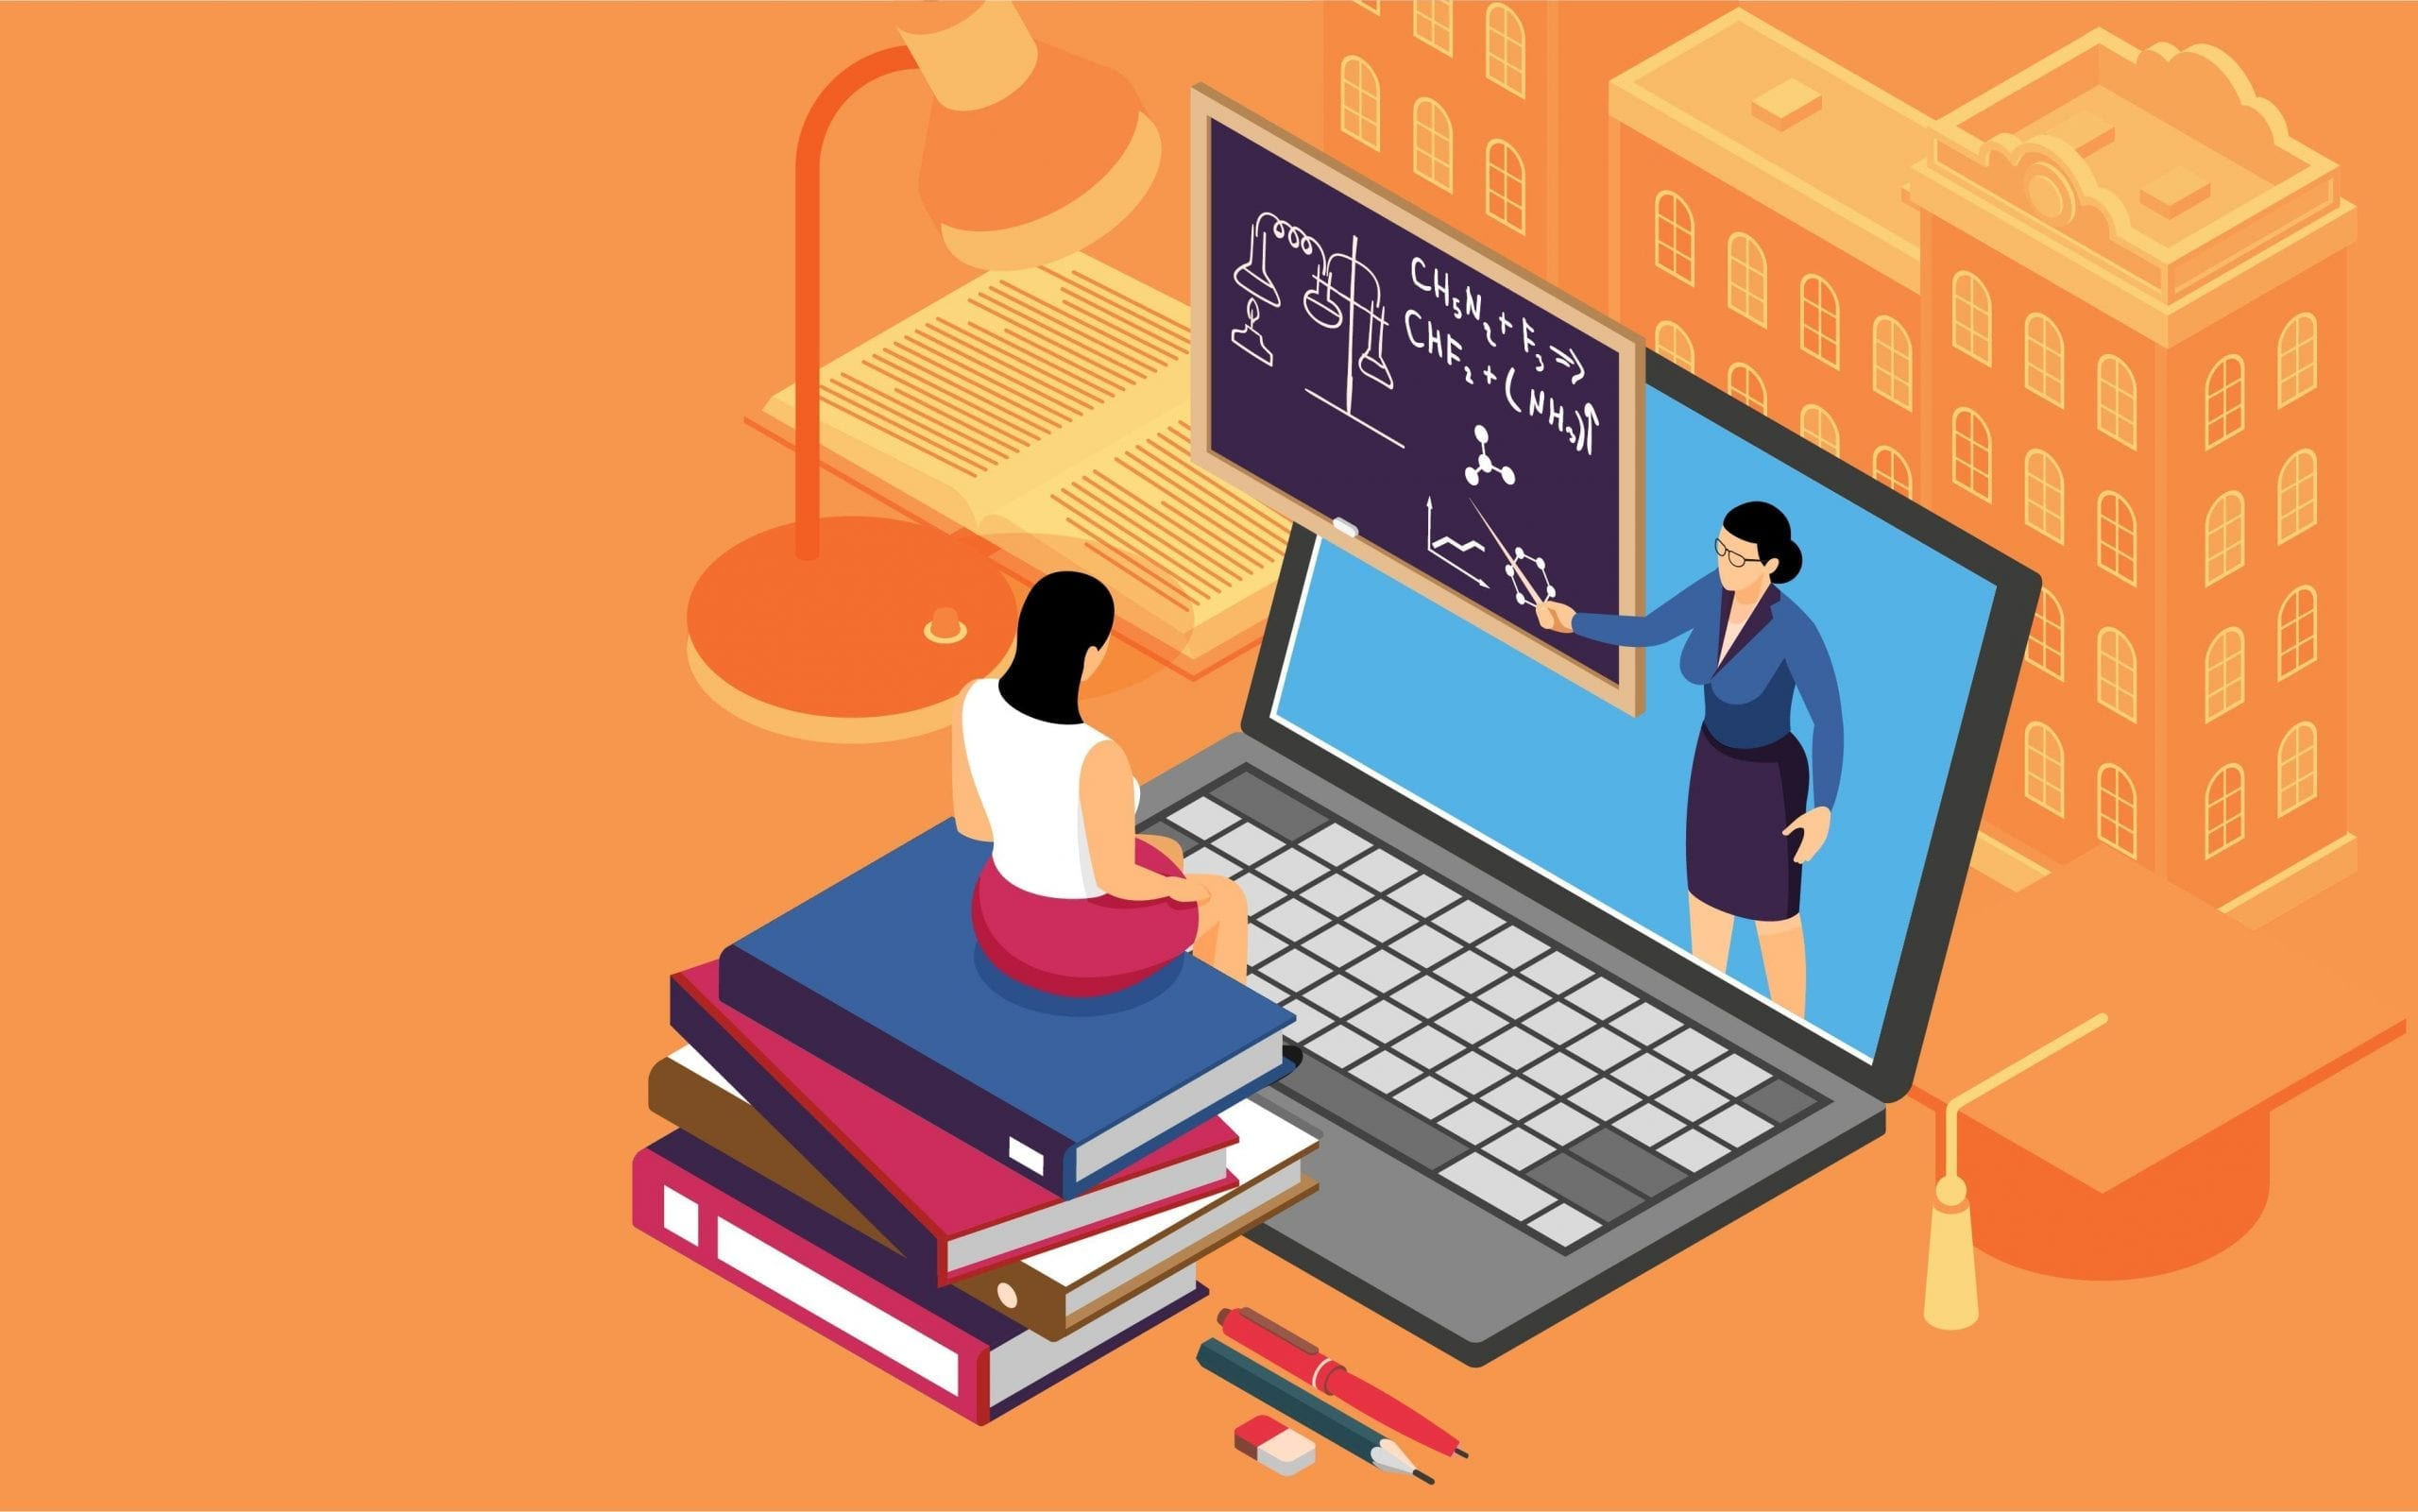

Online education services, such as Khan Academy and Coursera, provide a broader audience with access to high-quality education. On these platforms, students can learn new materials by watching a lecture, reading course material, and talking to instructors in a forum. However, one disadvantage of the online platform is that it is challenging to measure students’ understanding of the course material. To deal with this issue, many online education platforms include an assessment component to ensure that students understand the core topics. The assessment component is often composed of diagnostic questions, each a multiple choice question with one correct answer. The diagnostic question is designed so that each of the incorrect answers highlights a common misconception. When students incorrectly answer the diagnostic question, it reveals the nature of their misconception and, by understanding these misconceptions, the platform can offer additional guidance to help resolve them.

example of diagnostic question.png

In this project, you will build machine learning algorithms to predict whether a student can correctly
answer a specific diagnostic question based on the student’s previous answers to other questions
and other students’ responses. These predictions form the groundwork for many advanced customized tasks. For instance, using the predicted correctness, the online platform can automatically recommend a set of
diagnostic questions of appropriate difficulty that fit the student’s background and learning status.

*(Taken from the final project CSC311* [*handout*](http://www.cs.toronto.edu/~rgrosse/courses/csc311_f20/project/project.pdf)*)*

The next three sections were provided with the task description. You need to run "1. Download the starter code" and "2. Exploring the Dataset" sections to download the data. My work begins with the "Start of personal project" section.

# 1. Download the starter code

We first install the starter code from the course website

In [ ]:
!wget http://www.cs.toronto.edu/~rgrosse/courses/csc311_f20/project/final_project.zip
!unzip final_project.zip

--2023-06-19 02:28:46--  http://www.cs.toronto.edu/~rgrosse/courses/csc311_f20/project/final_project.zip
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444833 (434K) [application/zip]
Saving to: ‘final_project.zip.6’

final_project.zip.6 100%[===================>] 434.41K  2.02MB/s    in 0.2s    

2023-06-19 02:28:46 (2.02 MB/s) - ‘final_project.zip.6’ saved [444833/444833]

Archive:  final_project.zip
replace starter_code/majority_vote.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls starter_code/

data  majority_vote.py	part_a	__pycache__  utils.py


In [ ]:
!ls starter_code/data

private_test_data.csv  student_meta.csv  test_data.csv	 train_sparse.npz
question_meta.csv      subject_meta.csv  train_data.csv  valid_data.csv


Let's also add the environment variable so that we can use functions provided in the starter code (`utils.py`)

In [ ]:
import sys
sys.path.append('starter_code/')

We can now use all functions in ```utils.py```!



In [ ]:
from utils import *

# 2. Exploring the Dataset

The dataset is accessable in two ways:
* dictionary representation
* sparse matrix representation

We can use a different data format you for each learning algorithm we implement

### Dictionary Representation

Let's first load the training dataset in a dictionary

In [ ]:
train_data = load_train_csv("starter_code/data")

The datasets loaded is a dictionary that has three keys:

*   question_id: ID of the question answered (starts from 0)
*   user_id: ID of the student who answered the question (starts from 0)
*   is_correct: Binary indicator whether the student’s answer was correct (0 is incorrect, 1 is correct)

In [ ]:
train_data.keys()

dict_keys(['user_id', 'question_id', 'is_correct'])

We can examine how many entries we have for the training data

In [ ]:
len(train_data["user_id"])

56688

In [ ]:
len(train_data["user_id"]) == len(train_data["question_id"]) == len(train_data["is_correct"])

True

There are in total 56688 entries in the training data. We can further see how many unique students and questions we have in the training data

In [ ]:
len(set(train_data["user_id"])), len(set(train_data["question_id"])),

(542, 1774)

There are in total 542 unique users and 1774 unique questions!

Next, let's observe how many correct and incorrect answers there are in the training data

In [ ]:
import matplotlib.pyplot as plt

plt.hist(train_data["is_correct"], edgecolor='black', bins=2)
plt.xlabel("Correct")
plt.ylabel("Number")
plt.title("Histogram of Correct")
plt.show()

Correct answers ratio

In [ ]:
count_one = np.count_nonzero(train_data["is_correct"])
count_all = len(train_data["is_correct"])

iscorrect_ratio = count_one / count_all
iscorrect_ratio

0.5984335309060118

We have more correct answers than incorrect answers in the provided dataset

We can also see how many questions each student answered

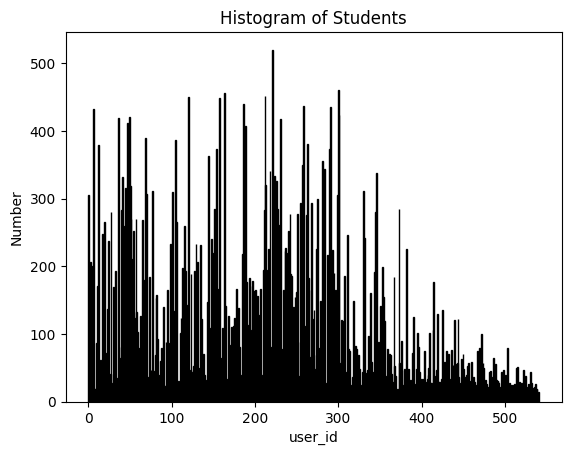

In [ ]:
plt.hist(train_data["user_id"], edgecolor='black', bins=542)
plt.xlabel("user_id")
plt.ylabel("Number")
plt.title("Histogram of Students")
plt.show()

Some students answered more questions and some students answered less questions

In [ ]:
user_answer_count = {i: 0 for i in range(0, 542)}
for u in train_data["user_id"]:
    user_answer_count[u] += 1

max(user_answer_count.values()), min(user_answer_count.values())

(520, 12)

The student with most answeres answered 520 questions and the student with least answers answered 12 question

We can also examine how many times each questions was answered

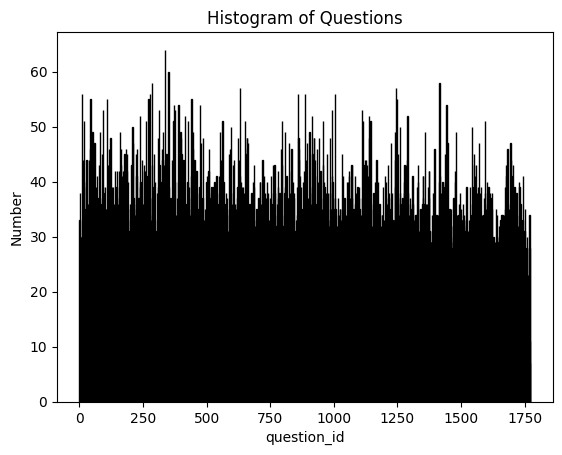

In [ ]:
plt.hist(train_data["question_id"], edgecolor='black', bins=1774)
plt.xlabel("question_id")
plt.ylabel("Number")
plt.title("Histogram of Questions")
plt.show()

In [ ]:
question_answer_count = {i: 0 for i in range(0, 1774)}
for u in train_data["question_id"]:
    question_answer_count[u] += 1

max(question_answer_count.values()), min(question_answer_count.values())

(64, 5)

The most answered question was answered 64 times and the least answered question was answered 5 times

For now, we only looked at the training dataset. However, the way in which the validation and test dataset are stored are the same

In [ ]:
valid_data = load_valid_csv("starter_code/data")
test_data = load_public_test_csv("starter_code/data")

In [ ]:
len(valid_data["user_id"]), len(test_data["user_id"])

(7086, 3543)

There are 7086 and 3543 entries for each validation and test data

In [ ]:
len(set(valid_data["user_id"])), len(set(valid_data["question_id"])),

(534, 1730)

In [ ]:
len(set(test_data["user_id"])), len(set(test_data["question_id"])),

(488, 1514)

And there are (534, 1730) unique entries for validation data and (488, 1514) unique entries for test data

### Sparse matrix representation

We can also load the dataset in sparse matrix representation

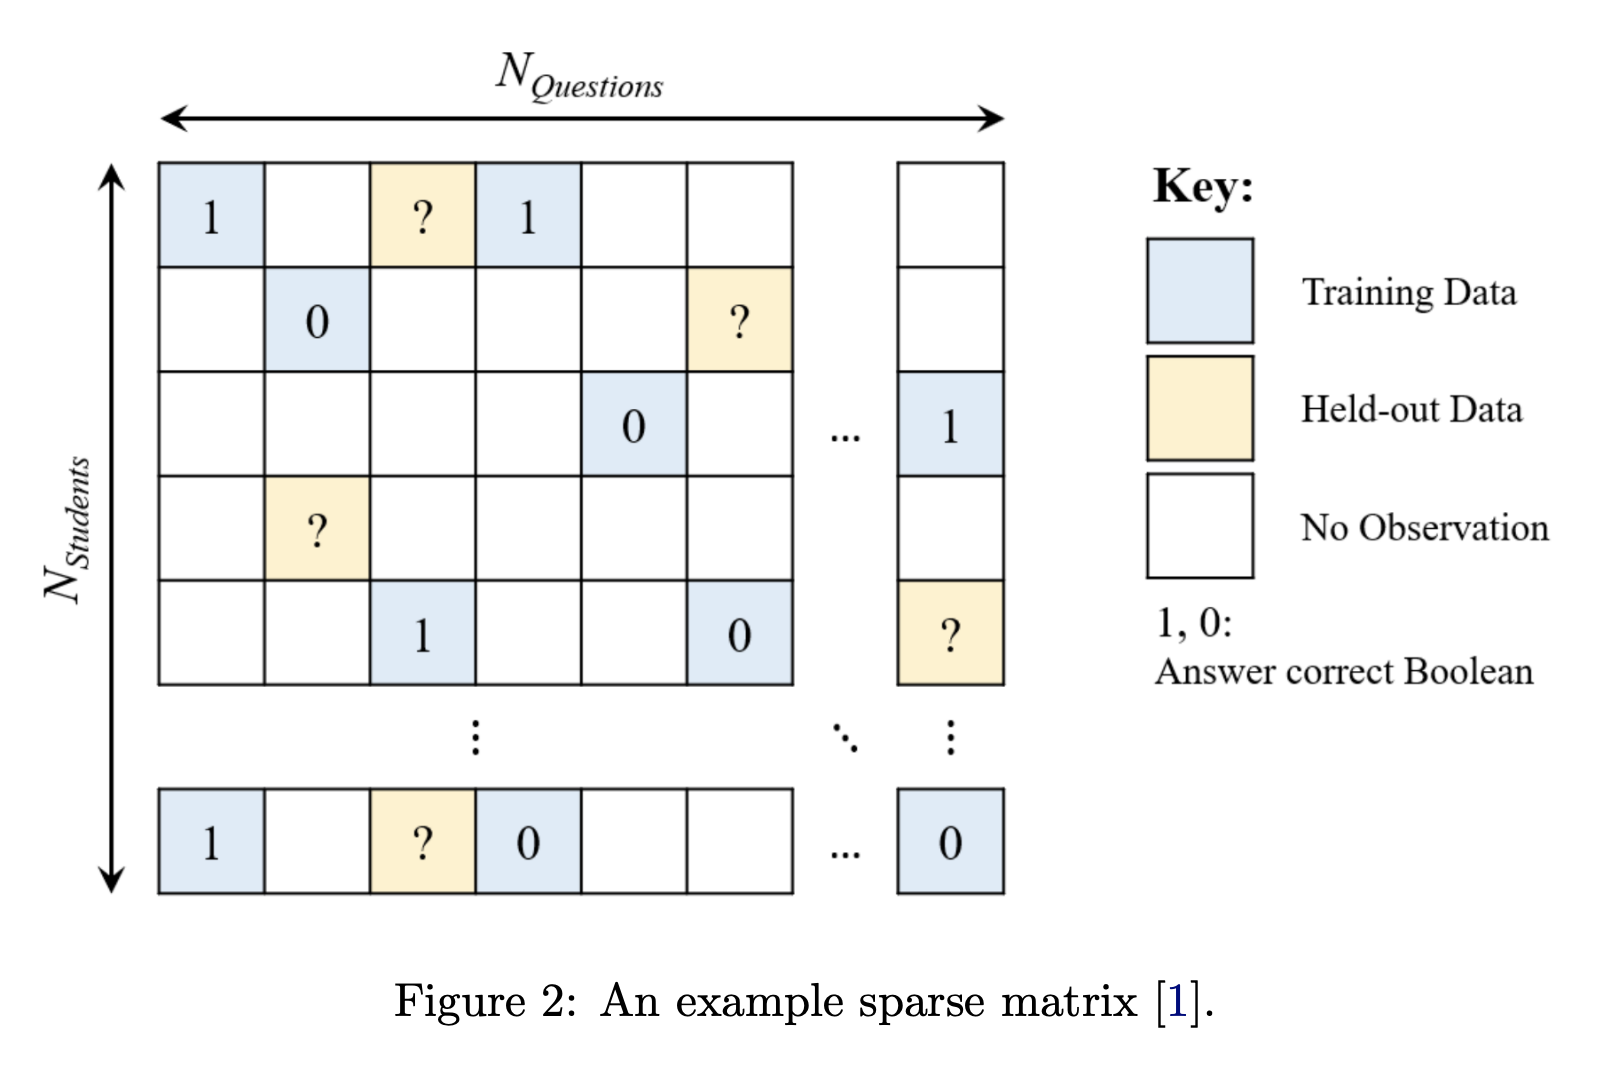

Each row corresponds to the user_id and each column corresponds to the question_id. The correct answer given a pair of (user_id, question_id) will have an entry 1 and an incorrect answer will have an entry 0. Answers with no observation and held-out data (that will be used for validation and test) will have an entry NaN (np.NaN)

In [ ]:
matrix = load_train_sparse("starter_code/data")

In [ ]:
matrix

<542x1774 sparse matrix of type '<class 'numpy.float64'>'
	with 938744 stored elements in Compressed Sparse Column format>

In [ ]:
matrix.shape

(542, 1774)

In [ ]:
matrix[0]

<1x1774 sparse matrix of type '<class 'numpy.float64'>'
	with 1620 stored elements in Compressed Sparse Column format>

As expected, the sparse matrix has 542 rows and 1774 columns

You may also change the type of the sparse matrix to numpy array by using `.toarray()` method

In [ ]:
matrix.toarray()

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan,  0., nan, ..., nan, nan, nan],
       [nan, nan,  1., ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

Let's visualize our sparse matrix

In [ ]:
import copy
temp_matrix = copy.deepcopy(matrix).toarray()
temp_matrix[temp_matrix == 0] = 1.
temp_matrix = np.nan_to_num(temp_matrix)
plt.figure(figsize=(20, 20))
plt.spy(temp_matrix, markersize=1)

We can also compute the sparsity of the matrix

In [ ]:
1 - np.isnan(matrix.toarray()).sum() / np.prod(matrix.shape)

0.058957387770044556

This means that only 5.9\% of the entries are filled in the training data

# 3. Example: prediction with majority vote

A very simple algorithm is to look whether the question was answered correctly more than 50 percent of the time. It will predict 1 if it was answered correctly more than 50 percent of the time and 0 otherwise

We first load all training, validation, and test data

In [ ]:
train_data = load_train_csv("starter_code/data")
valid_data = load_valid_csv("starter_code/data")
test_data = load_public_test_csv("starter_code/data")

We first need to compute how many times each question was answered correctly and incorrectly

In [ ]:
correct_question_map = {}
total_question_map = {}

# Count how many questions were correct.
for i, q in enumerate(train_data["question_id"]):

    if q in correct_question_map:
        if train_data["is_correct"][i] == 1:
            correct_question_map[q] += 1
    else:
        if train_data["is_correct"][i] == 1:
            correct_question_map[q] = 1

    if q in total_question_map:
        total_question_map[q] += 1
    else:
        total_question_map[q] = 1

Using these information let's predict the validation data and compute the accuracy. You may use the function `evaluate` to compute the accuracy

In [ ]:
predictions = []
for i, q in enumerate(valid_data["question_id"]):
    ratio = correct_question_map[q] / float(total_question_map[q])
    # If the question was answered correctly more than half
    # of the times, predict correct.
    if ratio >= 0.5:
        predictions.append(1.)
    else:
        predictions.append(0.)
# Evaluate your model using the new prediction.
acc = evaluate(valid_data, predictions)
print("Validation Accuracy: {}".format(acc))

Validation Accuracy: 0.6239062941010444


We can do the same for the test data

In [ ]:
predictions = []
for i, q in enumerate(test_data["question_id"]):
    ratio = correct_question_map[q] / float(total_question_map[q])
    if ratio >= 0.5:
        predictions.append(1.)
    else:
        predictions.append(0.)
acc = evaluate(test_data, predictions)
print("Test Accuracy: {}".format(acc))

Test Accuracy: 0.6248941574936494


We just built our first algorithm that has 62.88\% accuracy on the test data! The algorithms you build should have higher accuracy than this!

# Start of personal project
By Olena Bugaiova

## My choices

Each class member selected a set of algorithms for this problem such that different students worked on different algorithms trying to achieve the best result. We compared results with accuracy


### Algorithms

I selected Matrix Factorization algorithms because the type of our data is user-item interaction data where user is a student and item is a question and the data has a lot of missing values - answers on diagnostic questions that we want to predict. We approximate missing values by reconstructing user-item interaction matrix from lower-rank matrixes of latent factors. Latent factors group students and questions in such a way that students of the same group knowing one concept covered in diagnostic questions indicate that other students of this group might know this concept too. Based on this work we can perform the task in recommending diagnostic questions

***Matrix Factorization***
- Singular Value Decomposition (SVD)
- Non-negative Matrix Factorization (NMF)
- Logistic Matrix Factorization (LMF)


***Bayesian Optimization*** for hyperparameters turning


### Tools

For this project I selected existing implementation from popular libraries because they are well documented and good to know

- sklearn.decomposition: SVD and NMF
- implicit: LMF

- skopt: BayesSearchCV for Bayesian Optimization
- scipy: sparse for sparse matrixes

## Understanding the algorithms and tools

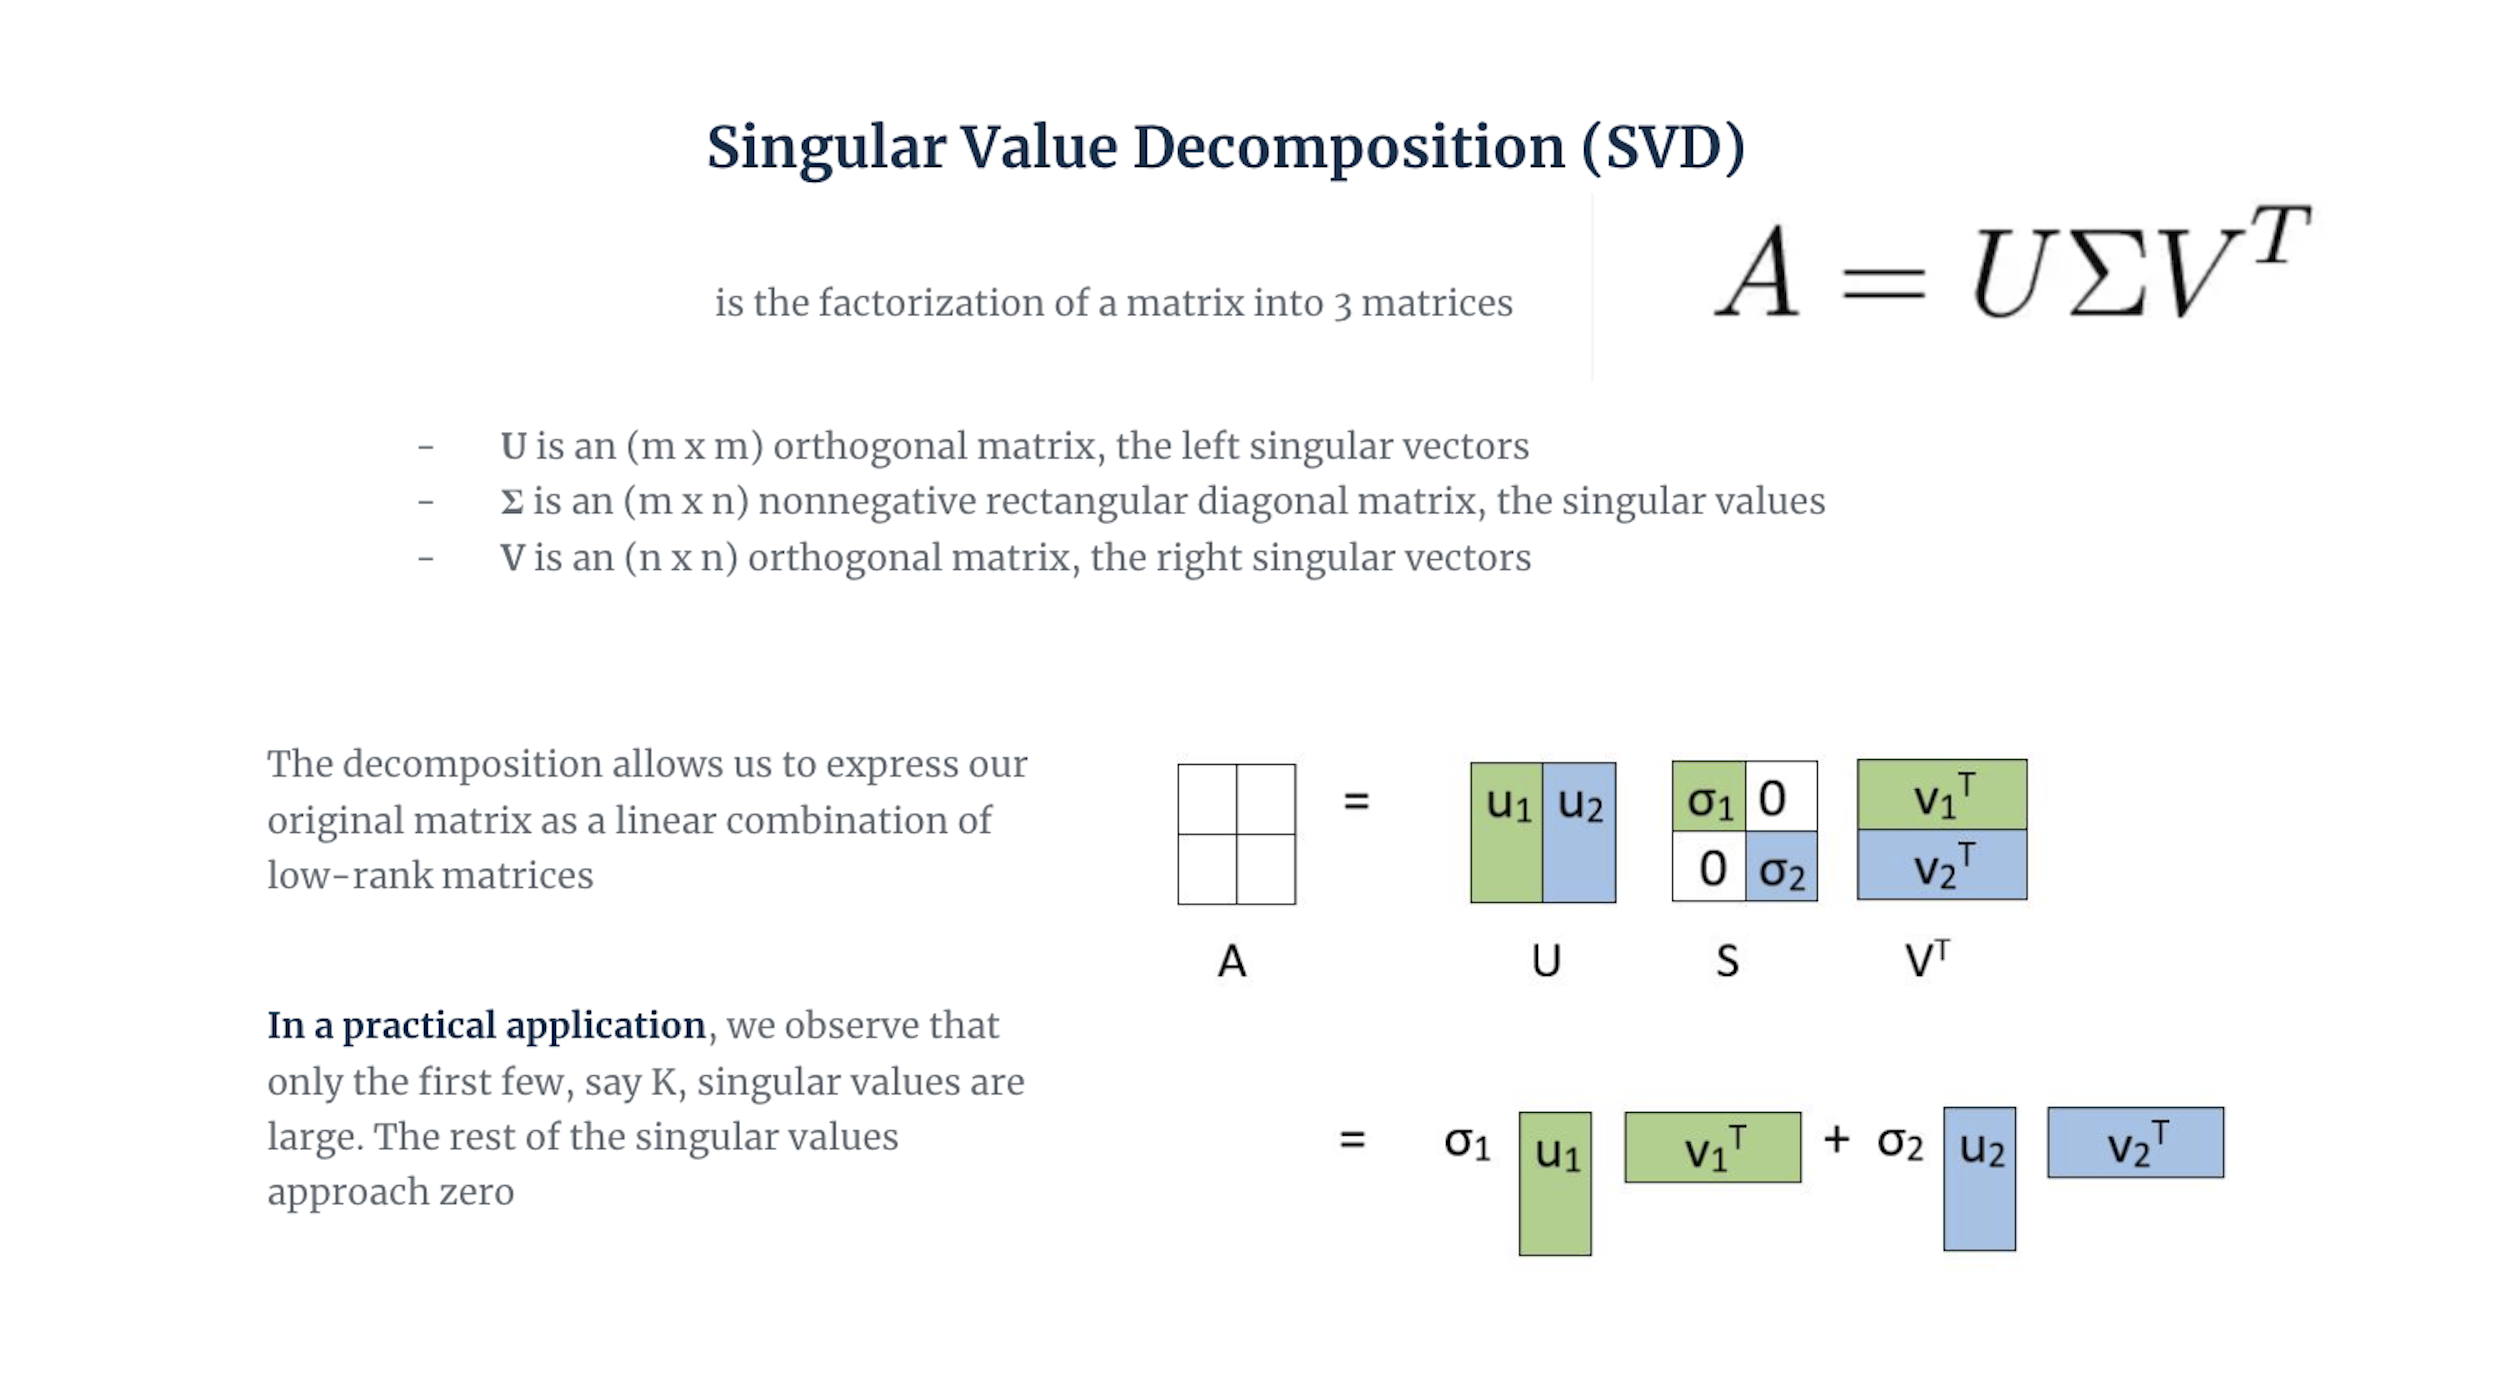

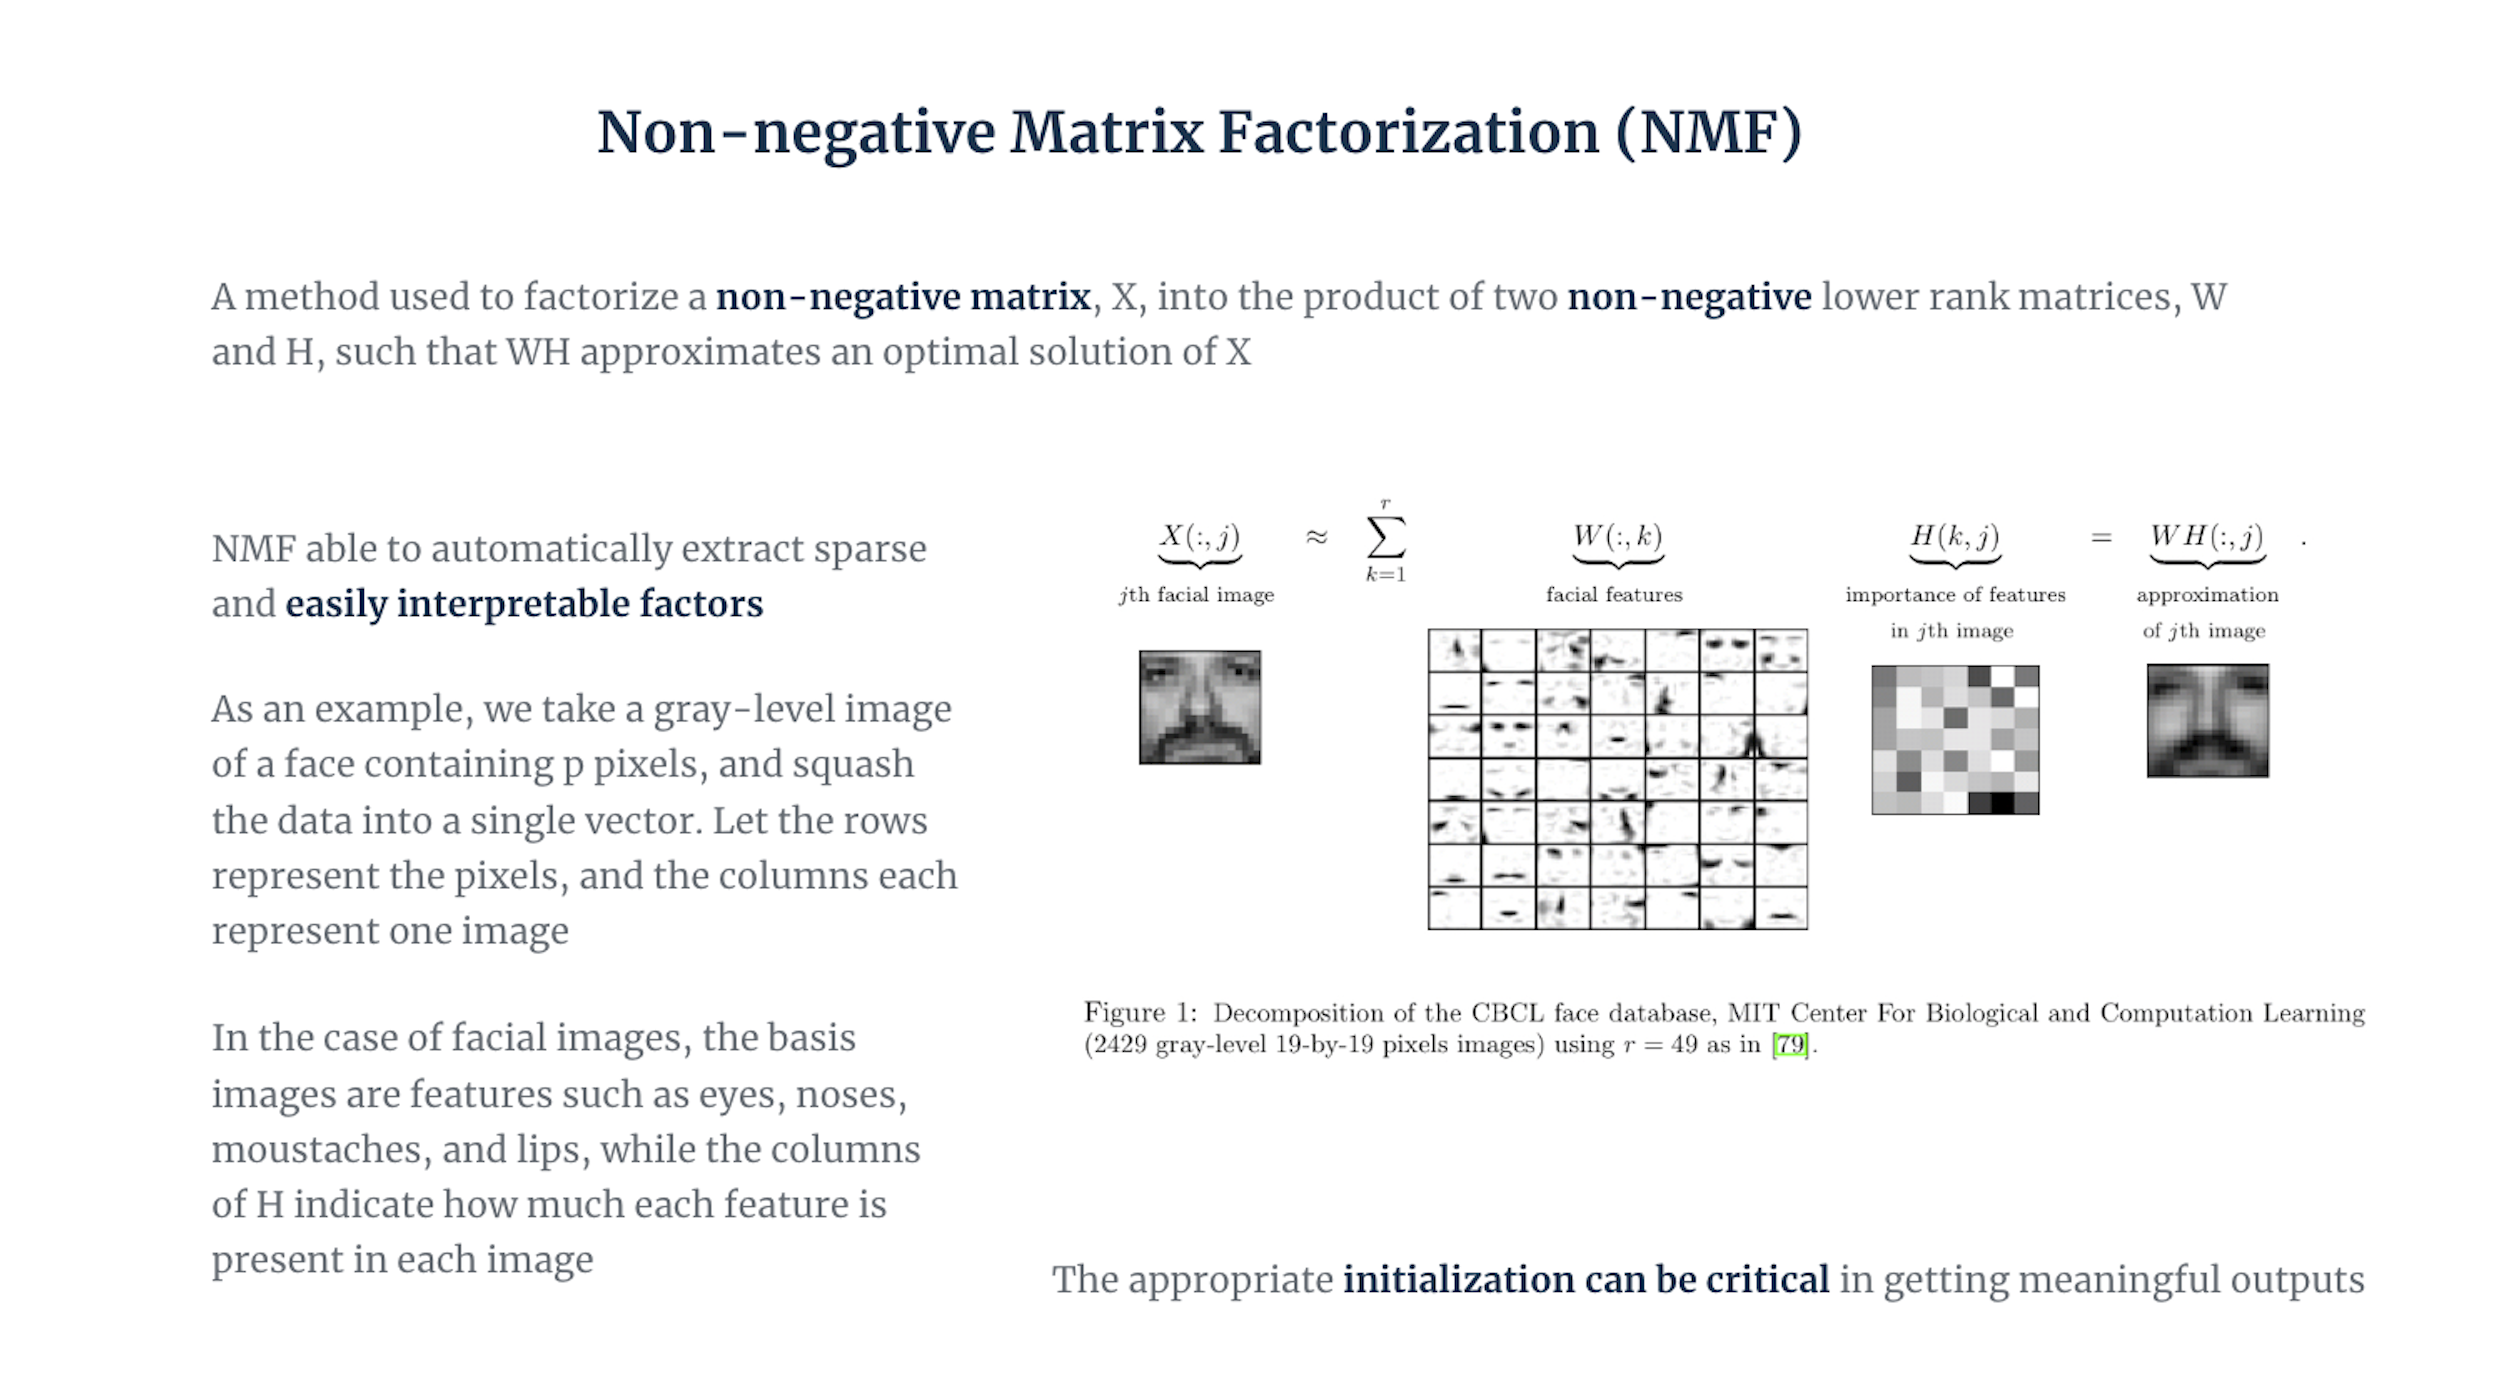

Taken from my [presentation](https://docs.google.com/presentation/d/1sVTWx80g80Ujr9pGMq5-RI7vAKU5gzfQ_4ea_x4nLl8/edit?usp=sharing) on Recommender Systems

**Logistic Matrix Factorization (LMF)**

learns probabilistic distribution whether a user likes something or not. Our model factorizes the observation matrix R by 2 lower dimensional matrices Xn×f and Ym×f where f is the number of latent factors... However, instead of minimizing the weighted RMSE between a binary based preference matrix and the product of U and V, we take a probabilistic approach with logistic loss.

Let lu,i denote the event that user u has chosen to interact with item i (user u prefers item i). Then, we can let the probability of this event occurring be distributed according to a logistic function parameterized by the sum of the inner product of user and item latent factor vectors and user and item biases.

sigmoid function in LMF.png


Given this formulation, let the positive entries of our observation matrix rui != 0 represent positive observations and the zero entries rui = 0 represent negative observations


Taken from [Logistic Matrix Factorization for Implicit
Feedback Data](https://web.stanford.edu/~rezab/nips2014workshop/submits/logmat.pdf)



**Tools**

**Sklearn.decomposition** module made for dimensionality reduction techniques mainly

**implicit** project made for recommendation algorithms for implicit feedback datasets but our data is explicit

**SciPy** is 2-D sparse array package for numeric data

## Applying the algorithms and tools to our data

**Data**
1.   has **only 5.9%** of the entries filled with values
2.   is **binary** with **zero values** for a negative event and **nan** for an absense of an event

How algorithms treat **missing values**:
  - SVD is only defined for complete matrices with no missing values
  - NMF in principle allows data to have missing values however NMF implementation from sklearn didn't allow nan values in the data
  - LMF accepts nan values but converts them to zero
  - Sparse matrixes treat nan values as zero for instance scipy.sparse.csr_matrix toarray() method converts nan to zero

Matrix factorization converts data into continuous values optimizing loss functions for such values

## Steps

- To add option for transformation from 0 and 1 to new binary values for instance -1, 1 in order to distinguish between negative results, posive results and missing values
- To impute missing values with fixed value like zero or with mean values for the algorithms depending on weather they can treat nan values or not and how they treat them
- To use threshold to convert predicted continues values to binary format

Also, I opened a feature request for handling nan values in NMF in sklearn

  This project is focused on the classification task however with the Matrix Factorization Algorithms we could perform the diagnostic questions ranking task using metrics for ranking like Mean Average Precision at K (MAP@K), read more in [presentation](https://docs.google.com/presentation/d/1sVTWx80g80Ujr9pGMq5-RI7vAKU5gzfQ_4ea_x4nLl8/edit?usp=sharing) on Recommender Systems

# 4. Import libraries

In [ ]:
!pip install implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install --upgrade scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import copy
import random
import pandas as pd
import numpy as np

In [ ]:
from abc import ABC, abstractmethod
from scipy.sparse import csr_matrix

In [ ]:
from implicit.lmf import LogisticMatrixFactorization

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.base import BaseEstimator
from sklearn.base import clone

from sklearn.utils.validation import check_is_fitted

In [ ]:
from skopt import BayesSearchCV

from skopt.plots import plot_objective
from skopt.plots import plot_convergence
from skopt.plots import plot_evaluations

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
RANDOM_STATE = 22

np.random.seed(seed = RANDOM_STATE)
random.seed(RANDOM_STATE)

# 5. Baseline models

Trained with default hyperparemeters

In [ ]:
display(matrix.toarray()[ : 5, : 4])

array([[nan, nan, nan, nan],
       [nan,  0., nan, nan],
       [nan, nan,  1., nan],
       [nan, nan,  0.,  1.],
       [nan, nan, nan, nan]])

## Data preprocessing parameters

We can set up binary values parameters and missing value imputation strategy and then execute code on the whole section

In [ ]:
DEFAULT_CORRECT_ANSWER = 1
DEFAULT_INCORRECT_ANSWER = 0

Set up new values for correct and incorrect answers and missing value imputation strategy

In [ ]:
incorrect_answer = 0
correct_answer = 1

binary_threshold = 0.5

mean_imputation_strategy = False
fixed_imputation_strategy = True

# only for fixed imputation strategy
fixed_value_for_nan = 0.5

In [ ]:
is_scaled = True
if correct_answer == DEFAULT_CORRECT_ANSWER and incorrect_answer == DEFAULT_INCORRECT_ANSWER:
    is_scaled = False

is_sparse = not fixed_imputation_strategy and not mean_imputation_strategy
is_negative = is_scaled and min(incorrect_answer, correct_answer) < 0
is_binary = not is_scaled and (is_sparse or (fixed_imputation_strategy and fixed_value_for_nan == 0))

## Data transformation

In [ ]:
def add_transformation(matrix, new_correct_answer = 1, new_incorrect_answer = -1):

    matrix[matrix == DEFAULT_INCORRECT_ANSWER] = 32
    matrix[matrix == DEFAULT_CORRECT_ANSWER] = new_correct_answer
    matrix[matrix == 32] = new_incorrect_answer
    return matrix

def remove_transformation(matrix, scaled_correct_answer = 1, scaled_incorrect_answer = -1):

    matrix[matrix == scaled_incorrect_answer] = 32
    matrix[matrix == scaled_correct_answer] = DEFAULT_CORRECT_ANSWER
    matrix[matrix == 32] = DEFAULT_INCORRECT_ANSWER

    return matrix

In [ ]:
input_matrix = copy.deepcopy(matrix).toarray()

In [ ]:
if is_scaled:
  input_matrix = add_transformation(input_matrix, correct_answer, incorrect_answer)

## Missing values imputation

In [ ]:
def fill_nan_with_fixed_value(matrix, fixed_value_for_nan = 0):

    matrix[np.isnan(matrix)] = fixed_value_for_nan

    return matrix

def fill_nan_with_mean(matrix):
    # obtain mean of columns
    col_mean = np.nanmean(matrix, axis = 0)

    # find indices that you need to replace
    inds = np.where(np.isnan(matrix))

    # place column means in the indices. Align the arrays using take
    matrix[inds] = np.take(col_mean, inds[1])

    return matrix, col_mean

In [ ]:
if fixed_imputation_strategy:
    input_matrix = fill_nan_with_fixed_value(input_matrix, fixed_value_for_nan)

In [ ]:
if mean_imputation_strategy:
    input_matrix, columns_mean = fill_nan_with_mean(input_matrix)

In [ ]:
input_matrix[: 5, : 5]

array([[0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0. , 0.5, 0.5, 0.5],
       [0.5, 0.5, 1. , 0.5, 0.5],
       [0.5, 0.5, 0. , 1. , 0.5],
       [0.5, 0.5, 0.5, 0.5, 0. ]])

## Singular Value Decomposition

In [ ]:
if is_sparse:
    matrix_svd = input_matrix
else:
    svd =  TruncatedSVD(random_state = RANDOM_STATE)
    matrix_transf_svd = svd.fit_transform(input_matrix)
    matrix_svd = svd.inverse_transform(matrix_transf_svd)

    print(svd.singular_values_)

[496.35572984  20.54477613]


## Logistic Matrix Factorization

In [ ]:
train_sparse_user_question = csr_matrix(
    (train_data['is_correct'], (train_data['user_id'], train_data['question_id']))
)

lmf = LogisticMatrixFactorization(random_state = RANDOM_STATE)
lmf.fit(train_sparse_user_question)

item_factors = lmf.item_factors
user_factors = lmf.user_factors

matrix_lmf = np.dot(user_factors, item_factors.T)

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
lmf.item_factors.shape

(1774, 32)

In [ ]:
lmf.user_factors.shape

(542, 32)

## Non-Negative Matrix Factorization

In [ ]:
if is_sparse or is_negative:
  matrix_nmf = input_matrix
else:
  nmf = NMF(random_state = RANDOM_STATE, verbose = 2)

  W = nmf.fit_transform(input_matrix)
  H = nmf.components_

  matrix_nmf = np.dot(W, H)

  display(np.max(matrix_nmf))

violation: 1.0
violation: 0.1279001096820875
violation: 0.07676404873338245
violation: 0.05568254577873812
violation: 0.04411958872731653
violation: 0.03694987323246481
violation: 0.031818752078825195
violation: 0.028154939941940443
violation: 0.02519944316861487
violation: 0.022779933920913147
violation: 0.020782568994863672
violation: 0.01902421764500105
violation: 0.017529725293809473
violation: 0.016230404274604187
violation: 0.015025661842295352
violation: 0.01402859974529477
violation: 0.013163933279010272
violation: 0.012371345730911958
violation: 0.011664796005963679
violation: 0.010973664447042729
violation: 0.010391727608779187
violation: 0.009859908136757847
violation: 0.00934954337767475
violation: 0.008892619384879997
violation: 0.008480503157565145
violation: 0.008074951133190433
violation: 0.007703015981471338
violation: 0.007379265322236367
violation: 0.0070556771681153626
violation: 0.006744087662337612
violation: 0.006454954104870475
violation: 0.006195829739831471
vi

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


1.0013148896951942

## Converting reconstructed matrix to binary form

In [ ]:
def convert_to_binary(matrix, threshold, top_value, bottom_value):

    matrix = np.where(matrix > threshold, top_value, bottom_value)
    return matrix

In [ ]:
def convert_to_initial_form(matrix):
    top = DEFAULT_CORRECT_ANSWER
    bottom = DEFAULT_INCORRECT_ANSWER

    if is_scaled:
        top = max(correct_answer, incorrect_answer)
        bottom = min(correct_answer, incorrect_answer)

    threshold = binary_threshold
    if mean_imputation_strategy:
        threshold = columns_mean

    matrix = convert_to_binary(matrix, threshold, top, bottom)

    if is_scaled:
        matrix = remove_transformation(
            matrix,
            scaled_correct_answer = correct_answer,
            scaled_incorrect_answer = incorrect_answer
            )

    return matrix

In [ ]:
if not is_sparse:
  matrix_svd = convert_to_initial_form(matrix_svd)

In [ ]:
if not is_sparse and not is_negative:
    matrix_nmf = convert_to_initial_form(matrix_nmf)

In [ ]:
matrix_lmf = convert_to_initial_form(matrix_lmf)

## Testing predictions

Get real values

In [ ]:
real_train = train_data["is_correct"]
real_valid = valid_data["is_correct"]
real_test = test_data["is_correct"]

Get predictions

In [ ]:
def get_predictions(data, matrix):
    predictions = []

    for u, q in zip(data['user_id'], data['question_id']):
        predictions.append(matrix[u, q])

    return predictions

In [ ]:
# predictions for SVD
predictions_train_svd = get_predictions(train_data, matrix_svd)
predictions_valid_svd = get_predictions(valid_data, matrix_svd)

In [ ]:
# predictions for NMF
predictions_train_nmf = get_predictions(train_data, matrix_nmf)
predictions_valid_nmf = get_predictions(valid_data, matrix_nmf)

In [ ]:
# predictions for LMF
predictions_train_lmf = get_predictions(train_data, matrix_lmf)
predictions_valid_lmf = get_predictions(valid_data, matrix_lmf)

Get scores

In [ ]:
def get_score(real_data, predictions):

    metrics = {}

    accuracy = accuracy_score(real_data, predictions)

    balanced_accuracy = balanced_accuracy_score(real_data, predictions)

    recall = recall_score(real_data, predictions)

    precision = precision_score(real_data, predictions)

    f1 = f1_score(real_data, predictions)

    metrics = {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_accuracy,
        'recall': recall,
        'precision': precision,
        'f1_score': f1
        }

    return metrics

In [ ]:
if not is_sparse:
    train_scores_svd = get_score(real_train, predictions_train_svd)
    valid_scores_svd = get_score(real_valid, predictions_valid_svd)

In [ ]:
if not (is_sparse or is_negative):
    train_scores_nmf = get_score(real_train, predictions_train_nmf)
    valid_scores_nmf = get_score(real_valid, predictions_valid_nmf)

In [ ]:
train_scores_lmf = get_score(real_train, predictions_train_lmf)
valid_scores_lmf = get_score(real_valid, predictions_valid_lmf)

In [ ]:
scores = []
column_names = []
if not is_sparse:
    scores.append(train_scores_svd)
    scores.append(valid_scores_svd)
    column_names.extend(['train_svd', 'valid_svd'])

if not is_sparse and not is_negative:
    scores.append(train_scores_nmf)
    scores.append(valid_scores_nmf)
    column_names.extend(['train_nmf', 'valid_nmf'])

scores.append(train_scores_lmf)
scores.append(valid_scores_lmf)
column_names.extend(['train_lmf', 'valid_lmf'])

## Result scores

In [ ]:
scores_df = pd.DataFrame.from_dict(
        scores
        )
scores_df = scores_df.T
scores_df.columns = column_names
display(scores_df.style.background_gradient(cmap = 'GnBu'))

We can see that
- SVD model performs well even on default hyperparameters
- NMF model overfits the data because the training score reaches the maximum value while the validation score is not much better than a random guess. It happens because by default NMF uses all features as factor values
- LMF model overfits as well but not as much as NMF by taking training score as 0.74

# 6. Improving models

With Bayesian Optimization

## Customized classes

### Customized estimators

Matrix factorization estimators with interface for hyperparameters turning customized for binary data

#### Base Estimator

In [ ]:
class BinaryMatrixFactorization(BaseEstimator, ABC):


      def __init__(
          self,
          correct_answer = 1,
          incorrect_answer = -1,
          binary_threshold = 0,
          value_for_nan = 0
        ):

        self.correct_answer = correct_answer
        self.incorrect_answer = incorrect_answer
        self.binary_threshold = binary_threshold
        self.value_for_nan = value_for_nan

        self._predicted_matrix = None

      def fit(self, data, y = None):

          matrix = self.get_input_matrix(data, self.value_for_nan)
          reconstructed_matrix = self.get_reconstructed_matrix(matrix)

          self._predicted_matrix = self.convert_to_binary(
              reconstructed_matrix,
              self.binary_threshold,
              self.correct_answer,
              self.incorrect_answer
              )

      @abstractmethod
      def get_reconstructed_matrix(self, matrix):
          pass

      def score(self, data, y = None):

          accuracy = self.get_accuracy_score(data, self._predicted_matrix)
          return accuracy

      @classmethod
      def get_input_matrix(cls, data, value_for_nan):

          """converts pandas dataframe into matrix
          Treats missing values according to the chosen strategy
          Args:
              data: given data in pandas dataframe format
              value_for_nan: fixed value to impute instead of missing values
          Returns:
              a matrix with handled missing values
          """

          if value_for_nan != 0:
              matrix = cls.get_matrix_with_nan_values(data)
              matrix = cls.fill_nan(matrix, value_for_nan)
          else:
              matrix = csr_matrix(
                  (data['is_correct'], (data['user_id'], data['question_id']))
                  ).toarray()

          return matrix

      @classmethod
      def get_accuracy_score(cls, data, predicted_matrix):

          predictions = cls.get_predictions(data, predicted_matrix)
          real_values = data["is_correct"]

          # we compare models based on accuracy during cross validation
          accuracy = accuracy_score(real_values, predictions)

          return accuracy

      @staticmethod
      def get_matrix_with_nan_values(data):

          """converts pandas dataframe into matrix keeping nan values
          Args:
              data: given data in pandas dataframe format
          Returns:
              a matrix with nan values
          """

          matrix_sparse = csr_matrix(
              (data['is_correct'], (data['user_id'], data['question_id']))
          )

          # we mark all non nan values as one
          mask = csr_matrix(([1] * len(data['is_correct']), (data['user_id'], data['question_id'])))

          # after converting sparse matrix to array, all nan values become zero
          mask = mask.toarray().astype(np.float32)

          # now we can replace zero with nan
          mask[mask == 0] = np.nan

          # get matrix of given data with nan for missing values
          matrix = matrix_sparse.toarray() * mask

          return matrix

      @staticmethod
      def fill_nan(matrix, value_for_nan):

          matrix[np.isnan(matrix)] = value_for_nan
          return matrix

      @staticmethod
      def get_predictions(data, predicted_matrix):
          predictions = []

          for u, q in zip(data['user_id'], data['question_id']):
              predictions.append(predicted_matrix[u, q])

          return predictions

      @staticmethod
      def convert_to_binary(matrix, threshold, top_value, bottom_value):

          matrix = np.where(matrix >= threshold, top_value, bottom_value)
          return matrix

#### SVD

In [ ]:
class BinarySVD(BinaryMatrixFactorization):


      def __init__(
        self,
        n_components: int = 2,
        algorithm = 'randomized',
        n_iter: int = 5,
        n_oversamples: int = 10,
        power_iteration_normalizer = 'auto',
        random_state: int = RANDOM_STATE,
        tol: float = 0.0,
        correct_answer = 1,
        incorrect_answer = -1,
        binary_threshold = 0,
        value_for_nan = 0
    ):
        super().__init__(
            correct_answer = correct_answer,
            incorrect_answer = incorrect_answer,
            binary_threshold = binary_threshold,
            value_for_nan = value_for_nan
            )

        self.n_components = n_components
        self.algorithm = algorithm
        self.n_iter = n_iter
        self.n_oversamples = n_oversamples
        self.power_iteration_normalizer = power_iteration_normalizer
        self.random_state = random_state
        self.tol = tol

      def get_reconstructed_matrix(self, matrix):

          print(type(self.n_components))

          model = TruncatedSVD(
              n_components = self.n_components,
              n_iter = self.n_iter,
              algorithm = self.algorithm,
              n_oversamples = self.n_oversamples,
              power_iteration_normalizer = self.power_iteration_normalizer,
              random_state = self.random_state,
              tol = self.tol
                )

          data_transformed = model.fit_transform(matrix)
          reconstructed_matrix = model.inverse_transform(data_transformed)

          return reconstructed_matrix

#### LMF

In [ ]:
class BinaryLMF(BinaryMatrixFactorization):


      def __init__(
        self,
        factors = 30,
        learning_rate = 1.0,
        regularization = 0.6,
        dtype = np.float32,
        iterations = 30,
        neg_prop = 30,
        use_gpu = False,
        num_threads = 0,
        random_state = RANDOM_STATE,
        correct_answer = 1,
        incorrect_answer = -1,
        binary_threshold = 0,
        value_for_nan = 0
    ):
        super().__init__(
            correct_answer = correct_answer,
            incorrect_answer = incorrect_answer,
            binary_threshold = binary_threshold,
            value_for_nan = value_for_nan
            )

        self.factors = factors
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.regularization = regularization
        self.dtype = np.dtype(dtype)
        self.neg_prop = neg_prop
        self.random_state = random_state
        self.use_gpu = use_gpu
        self.num_threads = num_threads

      def get_reconstructed_matrix(self, matrix):

          model = LogisticMatrixFactorization(
              factors = self.factors,
              learning_rate = self.learning_rate,
              regularization = self.regularization,
              dtype = self.dtype,
              iterations = self.iterations,
              neg_prop = self.neg_prop,
              use_gpu = self.use_gpu,
              num_threads = self.num_threads,
              random_state = self.random_state
                )

          model.fit(csr_matrix(matrix))

          item_factors = model.item_factors
          user_factors = model.user_factors

          reconstructed_matrix = np.dot(user_factors, item_factors.T)

          return reconstructed_matrix

#### NMF

In [ ]:
class BinaryNMF(BinaryMatrixFactorization):


      def __init__(
        self,
        n_components = None,
        *,
        init = None,
        solver = 'cd',
        beta_loss = 'frobenius',
        tol = 1e-4,
        max_iter = 200,
        random_state = RANDOM_STATE,
        alpha_W = 0.0,
        alpha_H = 'same',
        l1_ratio = 0.0,
        verbose = 0,
        shuffle = False,
        correct_answer = 1,
        incorrect_answer = 0,
        binary_threshold = 0.5,
        value_for_nan = 0.5
    ):
        super().__init__(
            correct_answer = correct_answer,
            incorrect_answer = incorrect_answer,
            binary_threshold = binary_threshold,
            value_for_nan = value_for_nan
            )

        self.n_components = n_components
        self.init = init
        self.beta_loss = beta_loss
        self.tol = tol
        self.max_iter = max_iter
        self.random_state = random_state
        self.alpha_W = alpha_W
        self.alpha_H = alpha_H
        self.l1_ratio = l1_ratio
        self.verbose = verbose
        self.solver = solver
        self.shuffle = shuffle

      def get_reconstructed_matrix(self, matrix):

          model = NMF(
              n_components = self.n_components,
              init = self.init,
              beta_loss = self.beta_loss,
              tol = self.tol,
              max_iter = self.max_iter,
              random_state = self.random_state,
              alpha_W = self.alpha_W,
              alpha_H = self.alpha_H,
              l1_ratio = self.l1_ratio,
              verbose = self.verbose,
              solver = self.solver,
              shuffle = self.shuffle
                )

          W = model.fit_transform(matrix);
          H = model.components_;

          reconstructed_matrix = np.dot(W, H)

          return reconstructed_matrix

### Data Transformer

For data transformation and retrieval

In [ ]:
class Singleton(object):

        def __new__(cls, *args, **kwds):
            it = cls.__dict__.get("__it__")
            if it is not None:
                return it
            cls.__it__ = it = object.__new__(cls)
            it.init(*args, **kwds)
            return it

        def init(self, *args, **kwds):
            pass

[Code of singleton](https://www.python.org/download/releases/2.2/descrintro/#__new__) and a [post about singleton in python](https://stackoverflow.com/questions/31875/is-there-a-simple-elegant-way-to-define-singletons)

To create a singleton class, you subclass from Singleton; each subclass will have a single instance, no matter how many times its constructor is called. To further initialize the subclass instance, subclasses should override 'init' instead of __init__ - the __init__ method is called each time the constructor is called

In [ ]:
class DataTransformer(Singleton):

      DEFAULT_CORRECT_ANSWER = 1
      DEFAULT_INCORRECT_ANSWER = 0

      def init(
          self
          ):
          self._binary_datasets = {}
          self._default_label = self.get_transformation_label(
              self.DEFAULT_INCORRECT_ANSWER, self.DEFAULT_CORRECT_ANSWER
              )
          self._binary_datasets[self._default_label] = self.get_default_data()


      def get_binary_data_for_cv(
          self,
          incorrect_answer = DEFAULT_INCORRECT_ANSWER,
          correct_answer = DEFAULT_CORRECT_ANSWER
          ) -> dict:

          """Retrieves given data converted to binary values specified in parameters
          If datasets don't exist converts default datasets to specified binary values
          Args:
              incorrect_answer: new value for incorrect answers
              correct_answer: new value for correct answers
          Returns:
              a dictionary of dataframes in format {'train':, 'valid':, 'test':, 'train_valid':}
          """

          transformation_key = self.get_transformation_label(
              incorrect_answer, correct_answer
              )

          if transformation_key not in self._binary_datasets:

              default_datasets = self._binary_datasets[self._default_label]

              requested_datasets = {}
              for datatype, dataset in default_datasets.items():
                  requested_datasets[datatype] = self.transform_binary_dataset(
                      dataset, incorrect_answer, correct_answer
                      )

              self._binary_datasets[transformation_key] = requested_datasets

          return self._binary_datasets[transformation_key]

      def get_default_data(self) -> dict:

          """Converts given train, valid and test datasets into pandas dataframe format
          Combines train and valid datasets for cross validation
          Returns:
              a dictionary of dataframes in format {'train':, 'valid':, 'test':, 'train_valid':}
          """

          datasets = {'train': train_data, 'valid': valid_data, 'test': test_data}
          dataframes = {}

          for data_type, data in datasets.items():
              df = self.convert_to_dataframe(data)
              dataframes[data_type] = df

          train_valid_df = pd.concat([dataframes['train'], dataframes['valid']])
          train_valid_df.reset_index(drop = True, inplace = True)
          dataframes['train_valid'] = train_valid_df

          return dataframes

      @staticmethod
      def transform_binary_dataset(
          df,
          incorrect_answer,
          correct_answer,
          given_incorrect_answer = DEFAULT_INCORRECT_ANSWER,
          given_correct_answer = DEFAULT_CORRECT_ANSWER
          ):

          df_transformed = df.copy()
          df_transformed['is_correct'] = np.where(
              (df_transformed['is_correct'] == given_incorrect_answer),
              incorrect_answer,
              df_transformed['is_correct']
              )

          df_transformed['is_correct'] = np.where(
              (df_transformed['is_correct'] == given_correct_answer),
              correct_answer,
              df_transformed['is_correct']
              )
          return df_transformed

      @staticmethod
      def get_transformation_label(incorrect_answer, correct_answer) -> str:

          key = str(incorrect_answer) + '_' + str(correct_answer)
          return key

      @staticmethod
      def convert_to_dataframe(data):

          df = pd.DataFrame(zip(data['user_id'], data['question_id'], data['is_correct']))
          df.columns = ['user_id', 'question_id', 'is_correct']

          return df

### Hyperparameters optimizer

In [ ]:
class HyperparameterOptimizer(BayesSearchCV):


      def __init__(
          self,
          model: BaseEstimator,
          hyperparameters_candidates_info: dict,
          n_iter: int = 100,
          cv: int = 3,
          return_train_score: bool = True,
          random_state: int = RANDOM_STATE,
          ):
          super().__init__(
            model,
            hyperparameters_candidates_info,
            n_iter = n_iter,
            cv = cv,
            return_train_score = return_train_score,
            random_state = random_state
            )

      def visualize_results(self):
          check_is_fitted(self, 'cv_results_')

          print("val. score: %s\n" % self.best_score_)

          print("best parameters: %s\n" % self.best_params_)
          print("best estimator: %s\n" % self.best_estimator_)

          _ = plot_convergence(self.optimizer_results_[0])
          plt.show()

          _ = plot_objective(self.optimizer_results_[0])
          plt.show()

          _ = plot_evaluations(self.optimizer_results_[0], bins = 10)
          plt.show()

          cv_results_df = pd.DataFrame(self.cv_results_)

          cv_results_df[['mean_test_score', 'mean_train_score']].plot(
              xlabel = 'number of iterations', ylabel = 'accuracy score', style=['o', 'rx']
              )

### Model Tester

Test model with selected hyperparameters

In [ ]:
class ModelTester:


      def __init__(
          self,
          model: BaseEstimator
          ):
          self._model = model

      def fit_test(self, train_data, test_data) -> float:

          self._model.fit(train_data)
          training_score = self._model.score(train_data)
          testing_score = self._model.score(test_data)

          print(f'training score: {training_score}')
          print(f'testing score: {testing_score}')

          return testing_score

## Hyperparameters turning

What is Bayesian Optimization?

> Bayesian Optimization is an optimization method that builds a probability model of the objective function of hyperparameter variables and uses it to select candidates for optimal hyperparameters to evaluate in the true objective function, [read more](https://machinelearningmastery.com/what-is-bayesian-optimization/). Bayesian Optimization differs from Random Search and Grid Search in that it improves the search speed using past performances, whereas the other two methods are uniform (or independent) of past evaluations. In that sense, Bayesian Optimization is like manual search, [read more](https://towardsdatascience.com/bayesian-optimization-concept-explained-in-layman-terms-1d2bcdeaf12f)



Flags for hyperparameters turning with cross validation

In [ ]:
run_svd_cv = False
run_lmf_cv = True
run_nmf_cv = False

### Hyperparameters:
 - factors
 - learning_rate
 - regularization
 - initialization
 - loss function

### SVD

##### Binary data preprocessing

In [ ]:
SVD_CORRECT_ANSWER = 1
SVD_INCORRECT_ANSWER = 0
SVD_BINARY_THRESHOLD = 0.5
SVD_MISSING_VALUE_IMPUTATION_STRATEGY = 0.5

In [ ]:
data_for_cv = DataTransformer().get_binary_data_for_cv(
    SVD_INCORRECT_ANSWER, SVD_CORRECT_ANSWER
    )
data_for_cv['train_valid'].tail()

user_id  question_id  is_correct
63769      133          157           1
63770       64          197           1
63771      415          479           0
63772      115          410           0
63773       77         1273           0

##### Hyperparameters turning

In [ ]:
if run_svd_cv:
    opt = HyperparameterOptimizer(
        BinarySVD(
            algorithm = 'randomized',
            n_iter = 50,
            power_iteration_normalizer = 'OR',
            random_state = RANDOM_STATE,
            correct_answer = SVD_CORRECT_ANSWER,
            incorrect_answer = SVD_INCORRECT_ANSWER,
            binary_threshold = SVD_BINARY_THRESHOLD,
            value_for_nan = SVD_MISSING_VALUE_IMPUTATION_STRATEGY
            ),
        {
            'n_components': (2, 100),
            'n_oversamples': (50, 1000)
        },
        n_iter = 100,
        cv = 3,
        return_train_score = True,
        random_state = RANDOM_STATE
    )

    opt.fit(data_for_cv['train_valid'])

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


<class 'int'>
<class 'int'>
<class 'int'>


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>


val. score: 0.691598457051463

best parameters: OrderedDict([('n_components', 2), ('n_oversamples', 530)])

best estimator: BinarySVD(binary_threshold=0.5, incorrect_answer=0, n_iter=50,
          n_oversamples=530, power_iteration_normalizer='OR',
          value_for_nan=0.5)



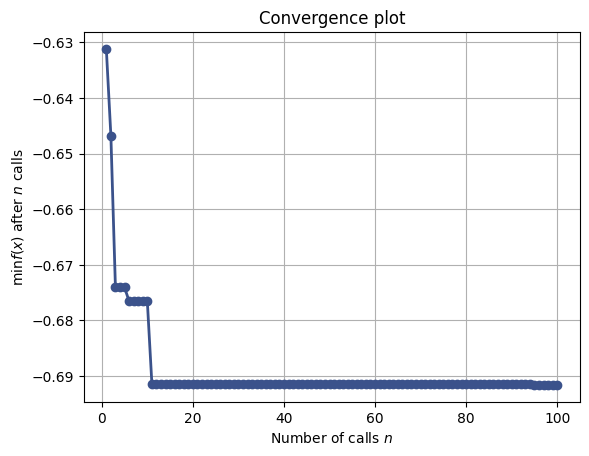

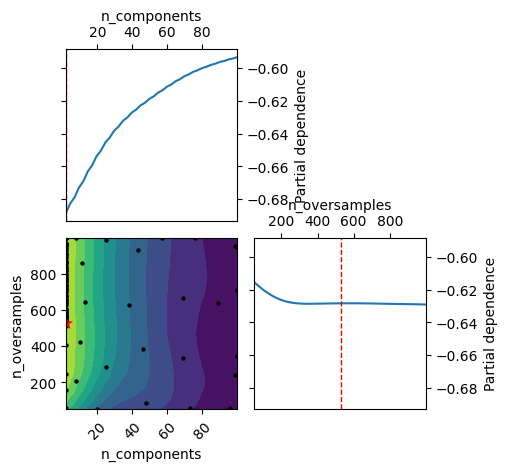

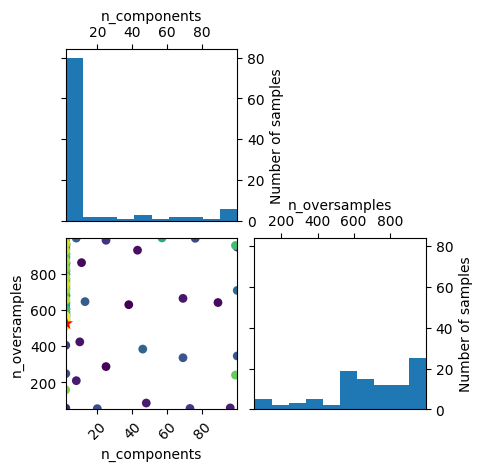

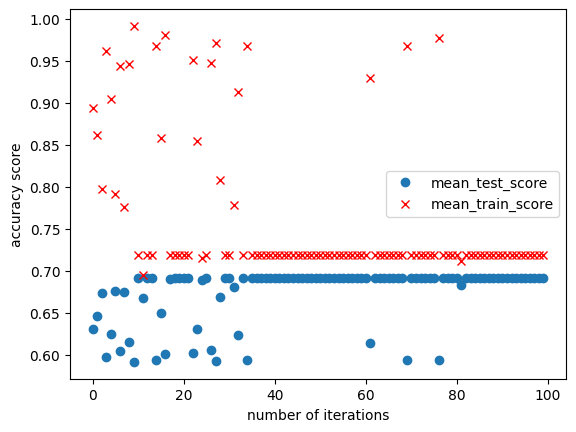

In [ ]:
if run_svd_cv:
    opt.visualize_results()

##### Testing model with selected hyperparameters

In [ ]:
if run_svd_cv:
    tester = ModelTester(opt.best_estimator_)
    tester.fit_test(data_for_cv['train'], data_for_cv['valid'])

<class 'int'>
training score: 0.7156541066892464
testing score: 0.6933389782670054


### LMF

##### Binary data preprocessing

In [ ]:
LMF_CORRECT_ANSWER = 1
LMF_INCORRECT_ANSWER = -1
LMF_BINARY_THRESHOLD = 0
LMF_MISSING_VALUE_IMPUTATION_STRATEGY = 0

In [ ]:
data_for_cv = DataTransformer().get_binary_data_for_cv(
    LMF_INCORRECT_ANSWER, LMF_CORRECT_ANSWER
    )
data_for_cv['train_valid'].tail()

user_id  question_id  is_correct
63769      133          157           1
63770       64          197           1
63771      415          479          -1
63772      115          410          -1
63773       77         1273          -1

##### Hyperparameters turning

In [ ]:
if run_lmf_cv:
    opt = HyperparameterOptimizer(
        BinaryLMF(
            random_state = RANDOM_STATE,
            iterations = 50,
            correct_answer = LMF_CORRECT_ANSWER,
            incorrect_answer = LMF_INCORRECT_ANSWER,
            binary_threshold = LMF_BINARY_THRESHOLD,
            value_for_nan = LMF_MISSING_VALUE_IMPUTATION_STRATEGY
            ),
        {
            'factors': (2, 400),
            'neg_prop': (1, 500),
            'learning_rate': (1e-7, 30.0, 'log-uniform'),
            'regularization': (1e-2, 150.0, 'log-uniform')
        },
        n_iter = 100,
        cv = 3,
        return_train_score = True,
        random_state = RANDOM_STATE
    )

    opt.fit(data_for_cv['train_valid'])

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

val. score: 0.6873961175400632

best parameters: OrderedDict([('factors', 2), ('learning_rate', 30.0), ('neg_prop', 500), ('regularization', 150.0)])

best estimator: BinaryLMF(dtype=dtype('float32'), factors=2, iterations=50, learning_rate=30.0,
          neg_prop=500, regularization=150.0)



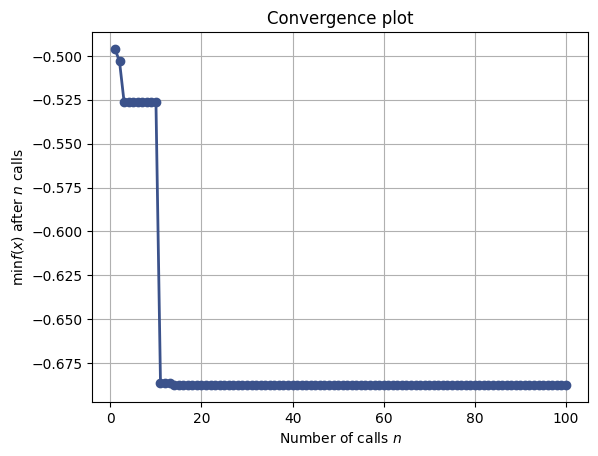

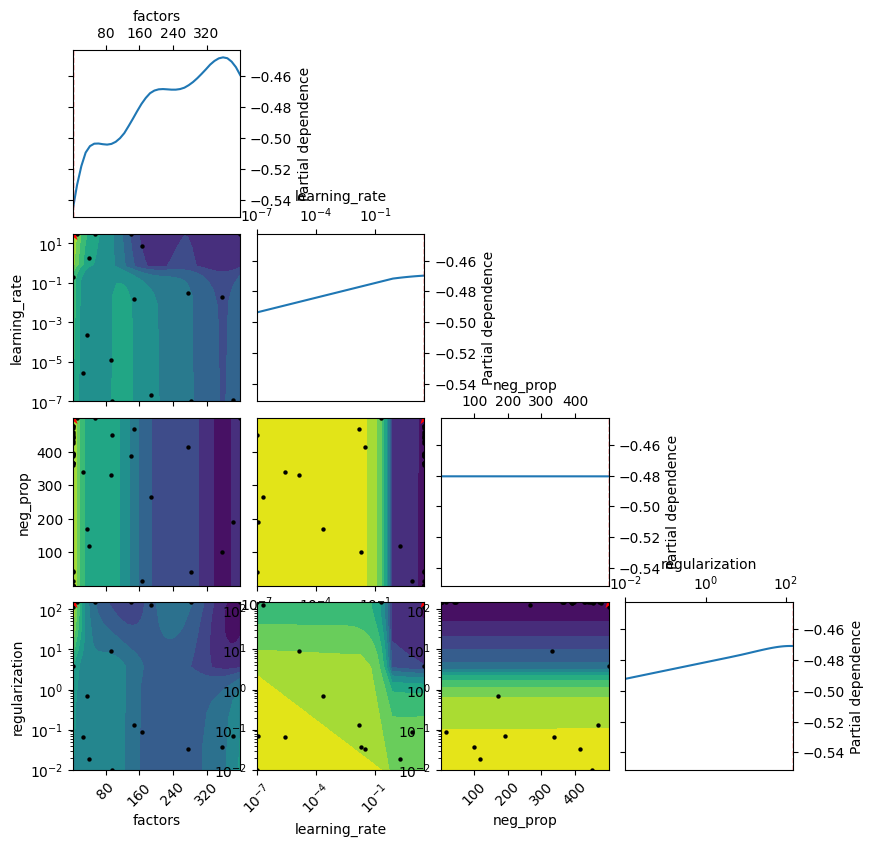

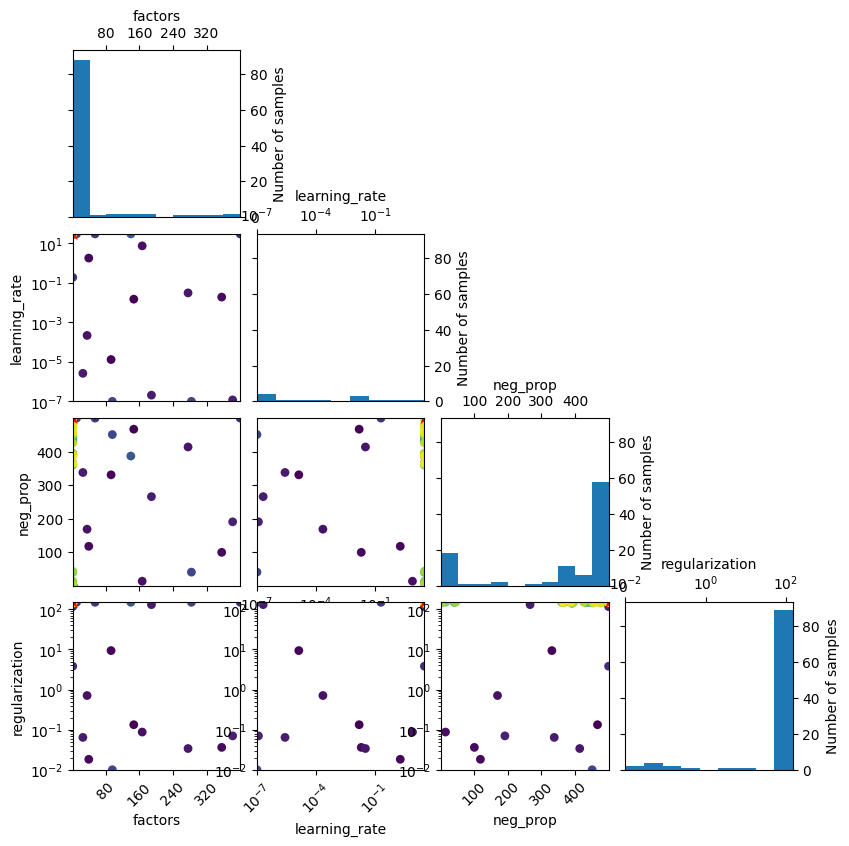

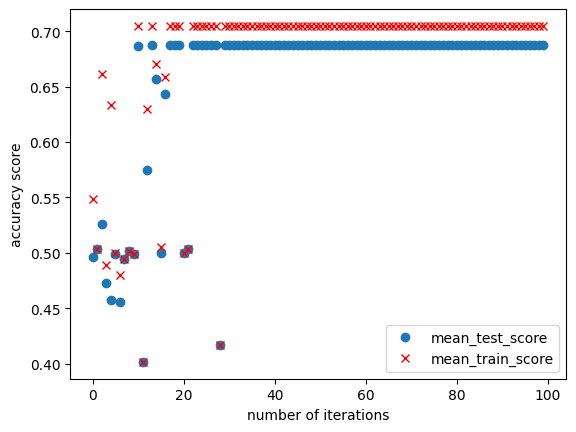

In [ ]:
if run_lmf_cv:
    opt.visualize_results()

##### Testing model with selected hyperparameters

In [ ]:
if run_lmf_cv:
    tester = ModelTester(opt.best_estimator_)
    tester.fit_test(data_for_cv['train'], data_for_cv['valid'])

  0%|          | 0/50 [00:00<?, ?it/s]

training score: 0.7027766017499294
testing score: 0.6892464013547841


### NMF

#### Binary data preprocessing

In [ ]:
NMF_CORRECT_ANSWER = 1
NMF_INCORRECT_ANSWER = 0
NMF_BINARY_THRESHOLD = 0.5
NMF_MISSING_VALUE_IMPUTATION_STRATEGY = 0.5

In [ ]:
data_for_cv = DataTransformer().get_binary_data_for_cv(
    NMF_INCORRECT_ANSWER, NMF_CORRECT_ANSWER
    )
data_for_cv['train_valid'].tail()

user_id  question_id  is_correct
63769      133          157           1
63770       64          197           1
63771      415          479           0
63772      115          410           0
63773       77         1273           0

#### Hyperparameters turning

In [ ]:
if run_nmf_cv:
    opt = HyperparameterOptimizer(
        BinaryNMF(
            init = 'random',
            solver = 'mu',
            beta_loss = 'kullback-leibler',
            max_iter = 1000,
            alpha_H = 0,
            tol = 0.01,
            random_state = RANDOM_STATE,
            verbose = 10,
            correct_answer = NMF_CORRECT_ANSWER,
            incorrect_answer = NMF_INCORRECT_ANSWER,
            binary_threshold = NMF_BINARY_THRESHOLD,
            value_for_nan = NMF_MISSING_VALUE_IMPUTATION_STRATEGY
            ),
        {
            'n_components': (2, 300),
            'alpha_W': (1e-4, 20.0, 'log-uniform'),
            'l1_ratio': (0.0, 1.0, 'uniform')
        },
        n_iter = 280,
        cv = 3,
        return_train_score = True,
        random_state = RANDOM_STATE
    )

    # add y for stratification
    y = data_for_cv['train_valid']["is_correct"]
    opt.fit(data_for_cv['train_valid'], y)

Epoch 10 reached after 1.181 seconds, error: 162.526952
Epoch 20 reached after 2.205 seconds, error: 160.914511
Epoch 10 reached after 1.036 seconds, error: 162.397807
Epoch 20 reached after 2.021 seconds, error: 160.785569
Epoch 10 reached after 1.022 seconds, error: 162.519623
Epoch 20 reached after 2.008 seconds, error: 160.899824
Epoch 10 reached after 0.908 seconds, error: 163.105051
Epoch 20 reached after 2.275 seconds, error: 161.493409
Epoch 10 reached after 1.336 seconds, error: 162.956000
Epoch 20 reached after 2.072 seconds, error: 161.341607
Epoch 10 reached after 0.812 seconds, error: 163.078722
Epoch 20 reached after 1.558 seconds, error: 161.466411
Epoch 10 reached after 0.435 seconds, error: 166.026024
Epoch 20 reached after 0.837 seconds, error: 163.980900
Epoch 10 reached after 0.474 seconds, error: 165.847030
Epoch 20 reached after 0.855 seconds, error: 163.818090
Epoch 10 reached after 0.859 seconds, error: 166.016762
Epoch 20 reached after 1.739 seconds, error: 163

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 10 reached after 0.186 seconds, error: 162.599755
Epoch 20 reached after 0.345 seconds, error: 162.591900
Epoch 10 reached after 0.223 seconds, error: 162.443201
Epoch 20 reached after 0.383 seconds, error: 162.435041
Epoch 10 reached after 0.227 seconds, error: 162.582272
Epoch 20 reached after 0.385 seconds, error: 162.574623


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 10 reached after 0.427 seconds, error: 162.599755
Epoch 20 reached after 0.753 seconds, error: 162.591900
Epoch 10 reached after 0.314 seconds, error: 162.443201
Epoch 20 reached after 0.666 seconds, error: 162.435041
Epoch 10 reached after 0.380 seconds, error: 162.582272
Epoch 20 reached after 0.707 seconds, error: 162.574623
Epoch 10 reached after 1.081 seconds, error: 162.476547
Epoch 20 reached after 2.079 seconds, error: 160.795593
Epoch 10 reached after 1.071 seconds, error: 162.306894
Epoch 20 reached after 2.102 seconds, error: 160.626197
Epoch 10 reached after 1.061 seconds, error: 162.447231
Epoch 20 reached after 2.092 seconds, error: 160.764368


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Epoch 10 reached after 0.231 seconds, error: 162.599755
Epoch 20 reached after 0.600 seconds, error: 162.591900
Epoch 10 reached after 0.357 seconds, error: 162.443201
Epoch 20 reached after 0.686 seconds, error: 162.435041
Epoch 10 reached after 0.389 seconds, error: 162.582272
Epoch 20 reached after 0.717 seconds, error: 162.574623
Epoch 10 reached after 0.185 seconds, error: 162.843230
Epoch 20 reached after 0.355 seconds, error: 162.592004
Epoch 10 reached after 0.197 seconds, error: 162.687744
Epoch 20 reached after 0.356 seconds, error: 162.435220
Epoch 10 reached after 0.195 seconds, error: 162.825625
Epoch 20 reached after 0.355 seconds, error: 162.575342
Epoch 10 reached after 0.224 seconds, error: 164.861886
Epoch 20 reached after 0.387 seconds, error: 162.717078
Epoch 10 reached after 0.198 seconds, error: 164.705110
Epoch 20 reached after 0.362 seconds, error: 162.560212
Epoch 10 reached after 0.213 seconds, error: 164.843609
Epoch 20 reached after 0.388 seconds, error: 162

val. score: 0.6902656254900116

best parameters: OrderedDict([('alpha_W', 3.622382295821057), ('l1_ratio', 0.04806338450777653), ('n_components', 2)])

best estimator: BinaryNMF(alpha_H=0, alpha_W=3.622382295821057, beta_loss='kullback-leibler',
          init='random', l1_ratio=0.04806338450777653, max_iter=1000,
          n_components=2, solver='mu', tol=0.01, verbose=10)



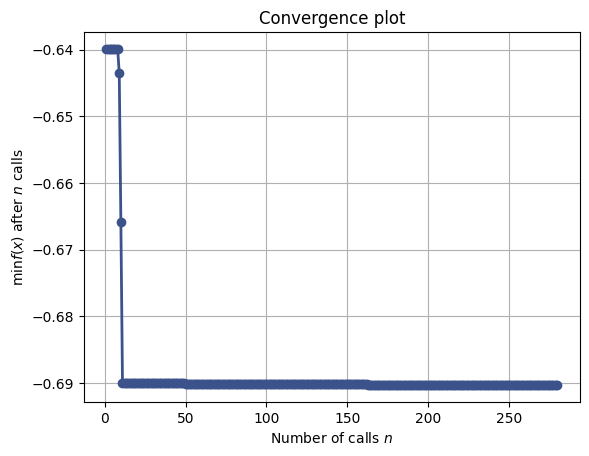

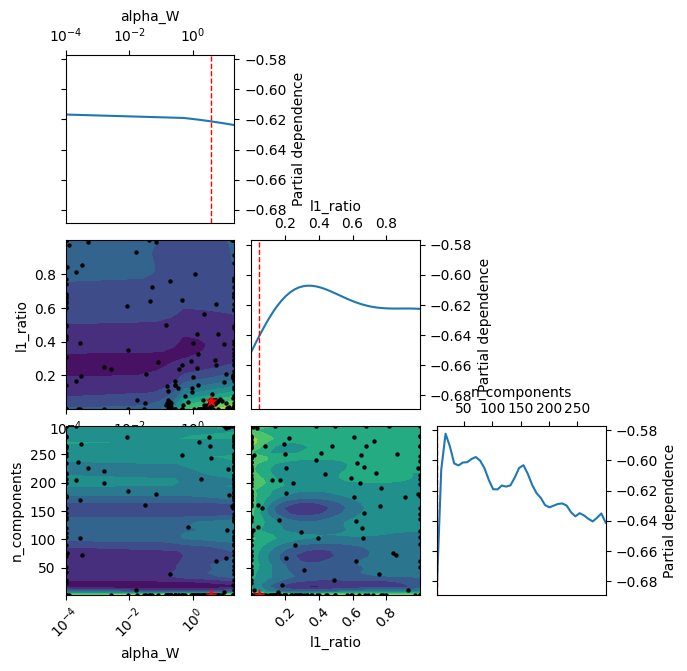

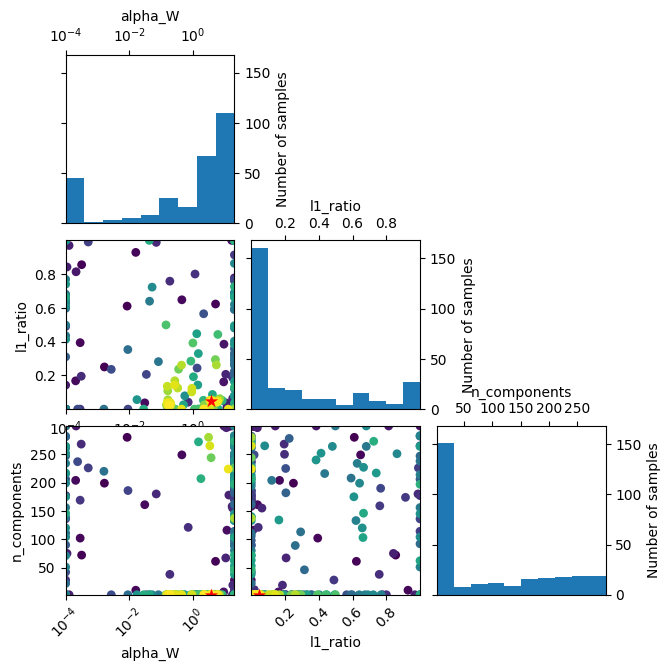

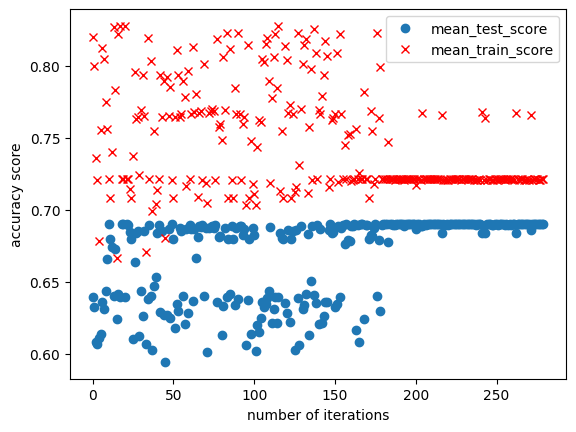

In [ ]:
if run_nmf_cv:
    opt.visualize_results()

#### Testing model with selected hyperparameters

In [ ]:
if run_nmf_cv:
    tester = ModelTester(opt.best_estimator_)
    tester.fit_test(data_for_cv['train'], data_for_cv['valid'])

Epoch 10 reached after 0.252 seconds, error: 187.252006
Epoch 20 reached after 0.531 seconds, error: 187.223169
training score: 0.7164126446514254
testing score: 0.6954558283940163


## Results

Initialize models with selected hyperparameters

In [ ]:
top_result_models = {}

In [ ]:
model_lmf = BinaryLMF(
    factors = 2,
    regularization = 150,
    learning_rate = 2.25,
    neg_prop = 500,
    iterations = 50,
    random_state = RANDOM_STATE,
    correct_answer = 1,
    incorrect_answer = -1,
    binary_threshold = 0,
    value_for_nan = 0
    )

top_result_models['lmf'] = {
    'model': model_lmf, 'correct_answer': 1, 'incorrect_answer': -1
    }

In [ ]:
model_svd = BinarySVD(
    n_components = 2,
    n_oversamples = 530,
    algorithm = 'randomized',
    n_iter = 50,
    power_iteration_normalizer = 'OR',
    random_state = RANDOM_STATE,
    correct_answer = 1,
    incorrect_answer = 0,
    binary_threshold = 0.5,
    value_for_nan = 0.5
    )

top_result_models['svd'] = {
    'model': model_svd, 'correct_answer': 1, 'incorrect_answer': 0
    }

In [ ]:
model_nmf = BinaryNMF(
    n_components = 2,
    alpha_W = 3.622,
    alpha_H = 0,
    l1_ratio = 0.048,
    init = 'random',
    solver = 'mu',
    beta_loss = 'kullback-leibler',
    max_iter = 100000,
    tol = 0.0001,
    random_state = RANDOM_STATE,
    correct_answer = 1,
    incorrect_answer = 0,
    binary_threshold = 0.5,
    value_for_nan = 0.5
  )

top_result_models['nmf'] = {
    'model': model_nmf, 'correct_answer': 1, 'incorrect_answer': 0
    }

In [ ]:
test_scores = {}
for model_name, top_result_model in top_result_models.items():

    tester = ModelTester(top_result_model['model'])

    data_for_testing = DataTransformer().get_binary_data_for_cv(
        top_result_model['incorrect_answer'], top_result_model['correct_answer']
        )
    tester.fit_test(data_for_testing['train'], data_for_testing['valid'])

    test_scores[model_name] = tester.fit_test(
        data_for_testing['train_valid'], data_for_testing['test']
        )

  0%|          | 0/50 [00:00<?, ?it/s]

training score: 0.7027766017499294
testing score: 0.6896697713801863


  0%|          | 0/50 [00:00<?, ?it/s]

training score: 0.7011164424373569
testing score: 0.6841659610499576
<class 'int'>
training score: 0.7156541066892464
testing score: 0.6933389782670054
<class 'int'>
training score: 0.7134255339166431
testing score: 0.6926333615580017
training score: 0.7164126446514254
testing score: 0.6954558283940163
training score: 0.7164988866936369
testing score: 0.6954558283940163


In [ ]:
scores = []
column_names = []

for model_name, model_score in test_scores.items():

    scores.append(model_score)
    column_names.append(model_name)

In [ ]:
scores_df = pd.DataFrame.from_dict(
        scores
        )
scores_df = scores_df.T
scores_df.columns = column_names

In [ ]:
print('Testing scores:')
display(scores_df.style.background_gradient(cmap = 'GnBu'))

Testing scores:


<Axes: title={'center': 'Testing Score'}>

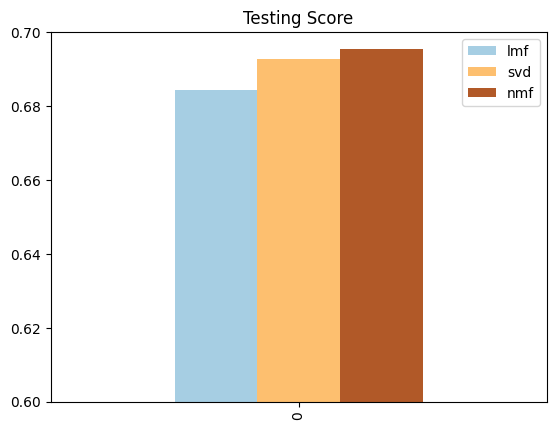

In [ ]:
scores_df.plot.bar(ylim = [0.6, 0.7], cmap = 'Paired', title='Testing Score')

# 7. NMF accepting missing values
Following code implemented for the "Handling NaNs in NMF" task on sklearn

Trying to solve missing values problem I found this git request that was frozen for a period of time

> [Add support to missing values in NMF](https://github.com/scikit-learn/scikit-learn/pull/8474)

Then I looked into code and found parameters responsible for turning on handling missing values. But It wasn't clear if there is any implementation behind. I decided to open a new feature request which was handled soon and is awaiting approval for a merge

> [Handling NaNs in NMF](https://github.com/scikit-learn/scikit-learn/issues/25229)


I downloaded source code from the feature request [ENH add support to missing values in NMF](https://github.com/scikit-learn/scikit-learn/pull/8474) from nmf_missing branch

And then trained NMF on the following hyperparameters:

```
nmf = NMF(
        n_components=2,
        alpha_W=20,
        alpha_H=0,
        l1_ratio=0.0,
        init='random',
        solver='mu',
        beta_loss='kullback-leibler',
        max_iter=10000,
        tol=0.001,
        random_state=22
)
```

In the case of missing values the next hyperparameters have to take the values:
- solver: 'mu'
- init method: 'random'

In PyCharm, I created a module with the next structure:

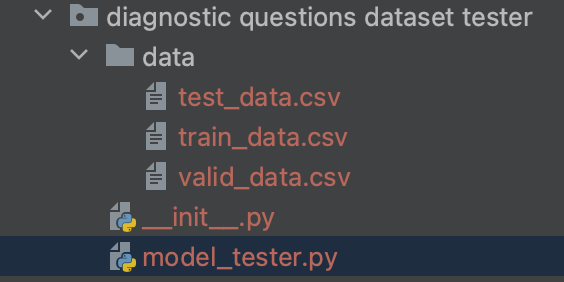

Where model_tester.py has the code shown below



```
import sklearn
from sklearn.decomposition import NMF

from sklearn.metrics import accuracy_score
from scipy.sparse import csc_array

import numpy as np
import pandas as pd

print(sklearn.__version__)


# ________________Retrieve data in required format___________________________________


def get_data_path(data_type: str):
    return 'data/' + data_type + '_data.csv'


def download_data(data_type: str):
    data_path = get_data_path(data_type)
    data = pd.read_csv(data_path)
    return data


def convert_to_dataframe(data):
    df = pd.DataFrame(
        zip(data['user_id'], data['question_id'], data['is_correct'])
    )
    df.columns = ['user_id', 'question_id', 'is_correct']
    return df


def convert_to_array_keeping_nan(data):
    mask = csc_array(([1] * len(data['is_correct']), (data['user_id'], data['question_id'])))

    mask = mask.toarray().astype(np.float32)
    # now we can mark zero as nan
    mask[mask == 0] = np.nan

    matrix_sparse = csc_array(
        (data.is_correct, (data.user_id, data.question_id))
    )
    data_nan_array = matrix_sparse.toarray() * mask
    return data_nan_array


data_types = ['train', 'valid', 'test']
given_data = {}

for d_type in data_types:
    given_data[d_type] = convert_to_dataframe(download_data(d_type))

train_valid_df = pd.concat([given_data['train'], given_data['valid']])
train_valid_df.reset_index(drop=True, inplace=True)
given_data['train_valid'] = train_valid_df

train_valid_nan_array = convert_to_array_keeping_nan(given_data['train_valid'])
train_nan_array = convert_to_array_keeping_nan(given_data['train'])

print("train_valid matrix[: 10, : 10]")
print(train_valid_nan_array[: 10, : 10])
print(train_valid_nan_array.shape)


# ________________Predict student-question interaction matrix___________________________________


nmf = NMF(
    n_components=2,
    alpha_W=20,
    alpha_H=0,
    l1_ratio=0.0,
    init='random',
    solver='mu',
    beta_loss='kullback-leibler',
    max_iter=100000,
    tol=0.001,
    random_state=22
)


def convert_to_binary(matrix):
    matrix = np.where(matrix - 0.5 > 0, 1, 0)
    return matrix


def get_predicted_matrix(data):
    W = nmf.fit_transform(data)
    H = nmf.components_

    reconstructed_matrix = np.dot(W, H)
    predicted_matrix = convert_to_binary(reconstructed_matrix)
    return predicted_matrix


predicted_matrixes = {
    'train': get_predicted_matrix(train_nan_array),
    'train_valid': get_predicted_matrix(train_valid_nan_array)
}


# ________________Test predictions___________________________________


real_values = {}
for d_type, df in given_data.items():
    real_values[d_type] = df['is_correct']

real_values['train_valid'] = pd.concat([real_values['train'], real_values['valid']], ignore_index = True)


def get_predictions(data, matrix):
    predictions = []

    for u, q in zip(data['user_id'], data['question_id']):
        predictions.append(matrix[u, q])

    return predictions


def get_score(real_data, predictions):
    accuracy = accuracy_score(real_data, predictions)
    return accuracy


# ________________Scores of predictions from train dataset___________________________________
print('Scores of predictions from nmf trained on train dataset')


train_scores_nmf = get_score(
    real_values['train'],
    get_predictions(given_data['train'], predicted_matrixes['train'])
)
valid_scores_nmf = get_score(
    real_values['valid'],
    get_predictions(given_data['valid'], predicted_matrixes['train'])
)

test_scores_nmf = get_score(
    real_values['test'],
    get_predictions(given_data['test'], predicted_matrixes['train'])
)

scores = []
column_names = []

scores.append(train_scores_nmf)
scores.append(valid_scores_nmf)
scores.append(test_scores_nmf)
column_names.extend(['train', 'valid', 'test'])

scores_df = pd.DataFrame.from_dict(
    scores
)
scores_df = scores_df.T
scores_df.columns = column_names

print(scores_df)

# ________________Scores of predictions from train_valid dataset___________________________________
print('Scores of predictions from nmf trained on train_valid dataset')

train_valid_scores_nmf = get_score(
    real_values['train_valid'],
    get_predictions(given_data['train_valid'], predicted_matrixes['train_valid'])
)

test_scores_nmf = get_score(
    real_values['test'],
    get_predictions(given_data['test'], predicted_matrixes['train_valid'])
)

scores = []
column_names = []

scores.append(train_valid_scores_nmf)
scores.append(test_scores_nmf)
column_names.extend(['train_valid', 'test'])

scores_df = pd.DataFrame.from_dict(
    scores
)
scores_df = scores_df.T
scores_df.columns = column_names

print(scores_df)

```



And after training the model I received such results:

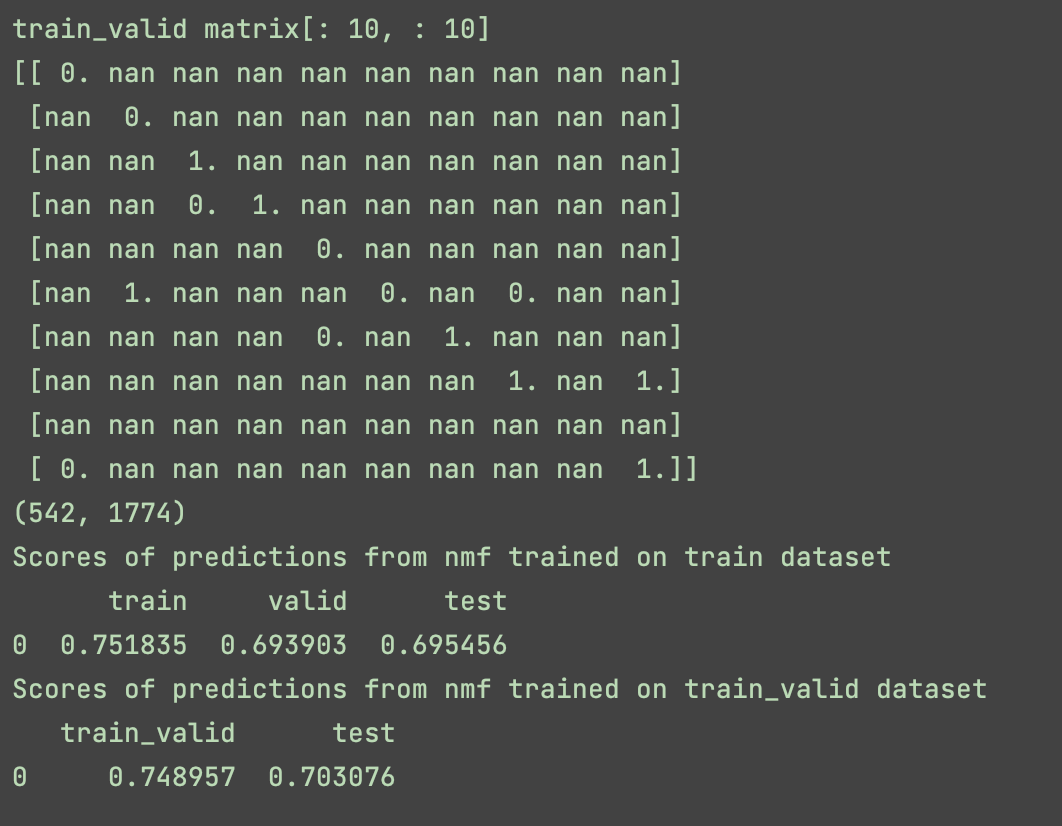

From this results we see that the testing score improves when we use more data for training. It makes sense because the algorithm focuses only on the present non nan values and we have only 5.9% of the entries filled with values

This model trained on the combined train and valid datasets gives the best performance over all the models

# 8. Summary

The best result all models produce with number of factors 2

NMF model achieves the highest score comparing to the models of other algorithms:
- 0.695456 accuracy on the algorithm that doesn't accept missing values
- 0.703076 accuracy on the algorithm that accepts missing values

For the NMF algorithm that accepts missing values the size of data and the amount of non nan values in data play an important role


On all algorithms, hyperparameters Optimization with cross validation converges to some consistent result after a certain number of iterations

# 9. Future steps

1. To implement ranking step using Matrix Factorization algorithms with ranking metric like MAP@K for recommending next diagnostic question to reveal students' misconseptions
2. To group data first and then apply Matrix Factorization Algorithms to each group. We can group data by types of questions taken from questions metadata, or by the result from clustering. For instance, this [notebook](https://github.com/NataliaNovosad/TUSK_final_project) perfomes clustering of the data. If the number of factors represent the number of groups of students and questions then with factor value 2 we probably capture only the high level features but not the variety of concepts in the learning material. With splitting by groups we could try to reveal more interesting subgroups that cover concepts from learning material
3. To try ensemble methods, hybrid approaches like these [types of hybrid recommender systems](https://medium.com/analytics-vidhya/7-types-of-hybrid-recommendation-system-3e4f78266ad8)
4. To use Matrix Factorization Algorithms for binary data like [Non-negative Matrix Factorization for Binary Data](https://www.scitepress.org/papers/2015/56148/56148.pdf) or [Binary Matrix Factorization with Applications](https://ranger.uta.edu/~chqding/papers/icdm07-binary.pdf)
5. Try to interpret meaning of latent factors with NMF
6. Implement an algotihms myself for binary data, accepting nan values, using logistic function and cross entropy loss function